In [190]:
import pickle
import os
import re
from wiki_utils import get_category_data
from network_utils import filter_graph_by_attribute, count_nodes_by_attribute
from sklearn.cluster import KMeans
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd

DOWNLOADS_DIR = "downloads"
RANDOM_STATE = 42
# Load the graph
S = pickle.load(open("graph.pkl", "rb"))


In [191]:

# Print original number of nodes and edges
print("Original graph: ")
print(f"Nodes: {S.number_of_nodes()}, Edges: {S.number_of_edges()}")
S_undirected = S.to_undirected()
print(f"Undirected graph: ")
print(f"Nodes: {S_undirected.number_of_nodes()}, Edges: {S_undirected.number_of_edges()}")

# Identify self-loop edges
self_loops = list(nx.selfloop_edges(S_undirected))

# Print nodes with self-loops
print(f"Nodes with self-loops: {[edge[0] for edge in self_loops]}")

# Remove self-loops
S_undirected.remove_edges_from(self_loops)

# Print updated number of nodes and edges
print("Graph after removing self-loops: ")
print(f"Nodes: {S_undirected.number_of_nodes()}, Edges: {S_undirected.number_of_edges()}")



Original graph: 
Nodes: 1366, Edges: 10850
Undirected graph: 
Nodes: 1366, Edges: 9021
Nodes with self-loops: ['Pierre_Teilhard_de_Chardin', 'Plato', 'Shen_Buhai', 'Otto_Rühle']
Graph after removing self-loops: 
Nodes: 1366, Edges: 9017


# Subfields communities

In [192]:
philosopher_subfield_info = pickle.load(open("philosopher_subfield_info.pkl", "rb"))

S_subfields = filter_graph_by_attribute(
    graph=S_undirected,
    attribute_info=philosopher_subfield_info,
    attribute_name='subfields',
    verbose=True
)
print("Subfield graph: ", S_subfields)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)

Did not find subfields for: 771 philosophers (therefore not included in the filtered graph)
 -> Example of removed nodes: ['Plutarch', 'Abraham_ibn_Ezra', 'Lucien_Lévy-Bruhl']
Original graph: 1366 nodes and 9017 edges
Filtered 'subfields' graph: 595 nodes and 4228 edges
Subfield graph:  Graph with 595 nodes and 4228 edges
--------------------------------------------------
Number of nodes by subfields:
 -> critical theorists: 41
 -> philosophers of science: 45
 -> sociopolitical thinkers: 131
 -> political philosophers: 135
 -> political theorists: 73
 -> ethicists: 115
 -> feminist philosophers: 23
 -> metaphysicians: 119
 -> logicians: 89
 -> philosophers of language: 68
 -> philosophers of mind: 57
 -> philosophers of religion: 49
 -> utilitarians: 29
 -> epistemologists: 78
 -> secular humanists: 34
 -> aestheticians: 51
 -> phenomenologists: 11
 -> environmental philosophers: 8
 -> rationalists: 17
 -> existentialists: 7
--------------------------------------------------


## First: Check full filtered network statistics

### Anyone important missing?

In [193]:
# Get degrees for all nodes in the original graph
degree_dict = dict(S_undirected.degree())

# Check if each node is in the filtered graph
presence = {node: (node in S_subfields) for node in S_undirected.nodes()}

# Combine degree and presence information
degree_data = [
    {'node': node, 'degree': degree, 'present': presence[node]}
    for node, degree in degree_dict.items()
]

# Sort nodes by degree in descending order
degree_data = sorted(degree_data, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes = [entry['node'] for entry in degree_data]
degrees = [entry['degree'] for entry in degree_data]
colors = ['blue' if entry['present'] else 'red' for entry in degree_data]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes))),
            y=degrees,
            marker_color=colors,
            text=nodes,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Original Graph (Red: Missing in Filtered Graph)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()


In [194]:
# print top nodes not present in the subfield graph
print("Most important philosophers not present in the subfield graph:")
for entry in degree_data[:1000]:
    if not entry['present']:
        print(entry['node'], entry['degree'])

Most important philosophers not present in the subfield graph:
Stanford_Encyclopedia_of_Philosophy 114
Isaac_Newton 72
Plutarch 57
Homer 46
Seneca_the_Younger 42
Ernst_Laas 38
Dante_Alighieri 37
Wilhelm_Wundt 34
Pierre_Gassendi 34
Galen 33
Nicolaus_Copernicus 28
Peter_Lombard 28
Lucian 28
Alexandre_Kojève 27
Jean_Wahl 26
Giordano_Bruno 25
Johannes_Kepler 25
Samuel_Clarke 25
Rudolf_Otto 25
Denis_Diderot 25
Moses_Mendelssohn 24
Kuno_Fischer 24
Miguel_Abensour 24
Edward_Gibbon 23
Franz_Kafka 23
Joseph_Butler 23
Ernst_Cassirer 23
Epictetus 23
Karl_Jaspers 23
William_Hazlitt 22
Paul_Ricœur 22
William_Blake 22
Benjamin_Fondane 22
Carl_Jung 22
Christiaan_Huygens 22
Lev_Shestov 21
Ralph_Cudworth 21
Emil_Cioran 21
Clement_of_Alexandria 21
George_Eliot 21
Josiah_Royce 21
Jean-Luc_Nancy 21
Étienne_Bonnot_de_Condillac 21
Friedrich_Heinrich_Jacobi 20
Ludwig_Klages 20
Karl_Barth 20
Mikhail_Bakhtin 20
Hermann_Weyl 20
Marcus_Aurelius 19
Mahatma_Gandhi 19
Gorgias 19
Lucilio_Vanini 18
Philo 18
Ptolemy 1

### Remove free nodes

In [195]:
# remove nodes that are not connected to the main component
largest_component = max(nx.connected_components(S_subfields), key=len)
#print nodes that are not in the largest component
for node in S_subfields.nodes:
    if node not in largest_component:
        print("Node not in largest component: ", node)
        print("Node attributes: ", S_subfields.nodes[node])


S_subfields = S_subfields.subgraph(largest_component).copy()
print("Subfield graph after removing unconnected nodes: ", S_subfields)
print("-"*50)
count_nodes_by_attribute(S_subfields, 'subfields', verbose=True)
print("-"*50)

Node not in largest component:  Ogyū_Sorai
Node attributes:  {'contentlength': 2172, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Marcion_of_Sinope
Node attributes:  {'contentlength': 2561, 'subfields': ['ethicists']}
Node not in largest component:  Dong_Zhongshu
Node attributes:  {'contentlength': 984, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Yi_I
Node attributes:  {'contentlength': 1546, 'subfields': ['sociopolitical thinkers']}
Node not in largest component:  Hayashi_Razan
Node attributes:  {'contentlength': 1579, 'subfields': ['sociopolitical thinkers']}
Subfield graph after removing unconnected nodes:  Graph with 590 nodes and 4227 edges
--------------------------------------------------
Number of nodes by subfields:
 -> critical theorists: 41
 -> philosophers of science: 45
 -> sociopolitical thinkers: 127
 -> political philosophers: 135
 -> political theorists: 73
 -> ethicists: 114
 -> feminist philosophers: 23
 -> m

### Fit degree distribution to subfields graph

In [196]:
import pickle
import numpy as np
import networkx as nx
from scipy.stats import poisson, expon, lognorm
import powerlaw
import warnings

# Ignore warnings from powerlaw package
warnings.filterwarnings("ignore")

# Step 2: Extract the degree sequence
degrees = np.array([d for n, d in S_subfields.degree()])
print(f"Minimum degree: {np.min(degrees)}")
print(f"Maximum degree: {np.max(degrees)}")

# Step 3: Fit candidate distributions using MLE

# 3a. Poisson Distribution
lambda_poisson = np.mean(degrees)
log_likelihood_poisson = np.sum(poisson.logpmf(degrees, lambda_poisson))

# 3b. Exponential Distribution (continuous approximation)
params_exp = expon.fit(degrees, floc=0)  # Fix loc=0
lambda_exp = 1 / params_exp[1]  # Scale parameter is 1/lambda
log_likelihood_exp = np.sum(expon.logpdf(degrees, *params_exp))

# 3c. Log-Normal Distribution
params_lognorm = lognorm.fit(degrees[degrees > 0], floc=0)  # Exclude zeros
sigma_lognorm, loc_lognorm, scale_lognorm = params_lognorm
log_likelihood_lognorm = np.sum(lognorm.logpdf(degrees[degrees > 0], *params_lognorm))

# 3d. Power-Law Distribution
fit = powerlaw.Fit(degrees, xmin=1)
alpha_powerlaw = fit.power_law.alpha
xmin_powerlaw = fit.power_law.xmin
log_likelihood_powerlaw = fit.power_law.loglikelihoods(degrees).sum()

# Step 4: Compute AIC and BIC for each model
n = len(degrees)

# Poisson
k_poisson = 1  # lambda
AIC_poisson = 2 * k_poisson - 2 * log_likelihood_poisson
BIC_poisson = k_poisson * np.log(n) - 2 * log_likelihood_poisson

# Exponential
k_exp = 1  # lambda
AIC_exp = 2 * k_exp - 2 * log_likelihood_exp
BIC_exp = k_exp * np.log(n) - 2 * log_likelihood_exp

# Log-Normal
n_lognorm = len(degrees[degrees > 0])
k_lognorm = 2  # sigma and scale
AIC_lognorm = 2 * k_lognorm - 2 * log_likelihood_lognorm
BIC_lognorm = k_lognorm * np.log(n_lognorm) - 2 * log_likelihood_lognorm

# Power-Law
n_powerlaw = len(degrees[degrees >= xmin_powerlaw])
k_powerlaw = 2  # alpha and xmin
AIC_powerlaw = 2 * k_powerlaw - 2 * log_likelihood_powerlaw
BIC_powerlaw = k_powerlaw * np.log(n_powerlaw) - 2 * log_likelihood_powerlaw

# Step 5: Select the best-fitting model based on AIC and BIC
AICs = {
    'Poisson': AIC_poisson,
    'Exponential': AIC_exp,
    'Log-Normal': AIC_lognorm,
    'Power-Law': AIC_powerlaw
}

BICs = {
    'Poisson': BIC_poisson,
    'Exponential': BIC_exp,
    'Log-Normal': BIC_lognorm,
    'Power-Law': BIC_powerlaw
}

best_fit_aic = min(AICs, key=AICs.get)
best_fit_bic = min(BICs, key=BICs.get)

# Output results
print("\nModel fitting results:")
print("-----------------------")
print("Log-Likelihoods:")
print(f"Poisson: {log_likelihood_poisson}")
print(f"Exponential: {log_likelihood_exp}")
print(f"Log-Normal: {log_likelihood_lognorm}")
print(f"Power-Law: {log_likelihood_powerlaw}\n")

print("AIC values:")
for dist, aic in AICs.items():
    print(f"{dist}: {aic}")
print(f"Best fit according to AIC: {best_fit_aic}\n")

print("BIC values:")
for dist, bic in BICs.items():
    print(f"{dist}: {bic}")
print(f"Best fit according to BIC: {best_fit_bic}\n")

print("Estimated parameters:")
print("---------------------")
print(f"Poisson lambda: {lambda_poisson}")
print(f"Exponential lambda: {lambda_exp}")
print(f"Log-Normal sigma: {sigma_lognorm}, scale: {scale_lognorm}")
print(f"Power-Law alpha: {alpha_powerlaw}, xmin: {xmin_powerlaw}")

Minimum degree: 1
Maximum degree: 157

Model fitting results:
-----------------------
Log-Likelihoods:
Poisson: -4813.501713960994
Exponential: -2160.740742093912
Log-Normal: -2118.142843923011
Power-Law: -2375.119141478771

AIC values:
Poisson: 9629.003427921987
Exponential: 4323.481484187824
Log-Normal: 4240.285687846022
Power-Law: 4754.238282957542
Best fit according to AIC: Log-Normal

BIC values:
Poisson: 9633.383550458888
Exponential: 4327.861606724724
Log-Normal: 4249.045932919821
Power-Law: 4762.998528031341
Best fit according to BIC: Log-Normal

Estimated parameters:
---------------------
Poisson lambda: 14.328813559322034
Exponential lambda: 0.06978944878164182
Log-Normal sigma: 0.9469913592994238, scale: 9.259030946162943
Power-Law alpha: 1.4493171604975035, xmin: 1.0


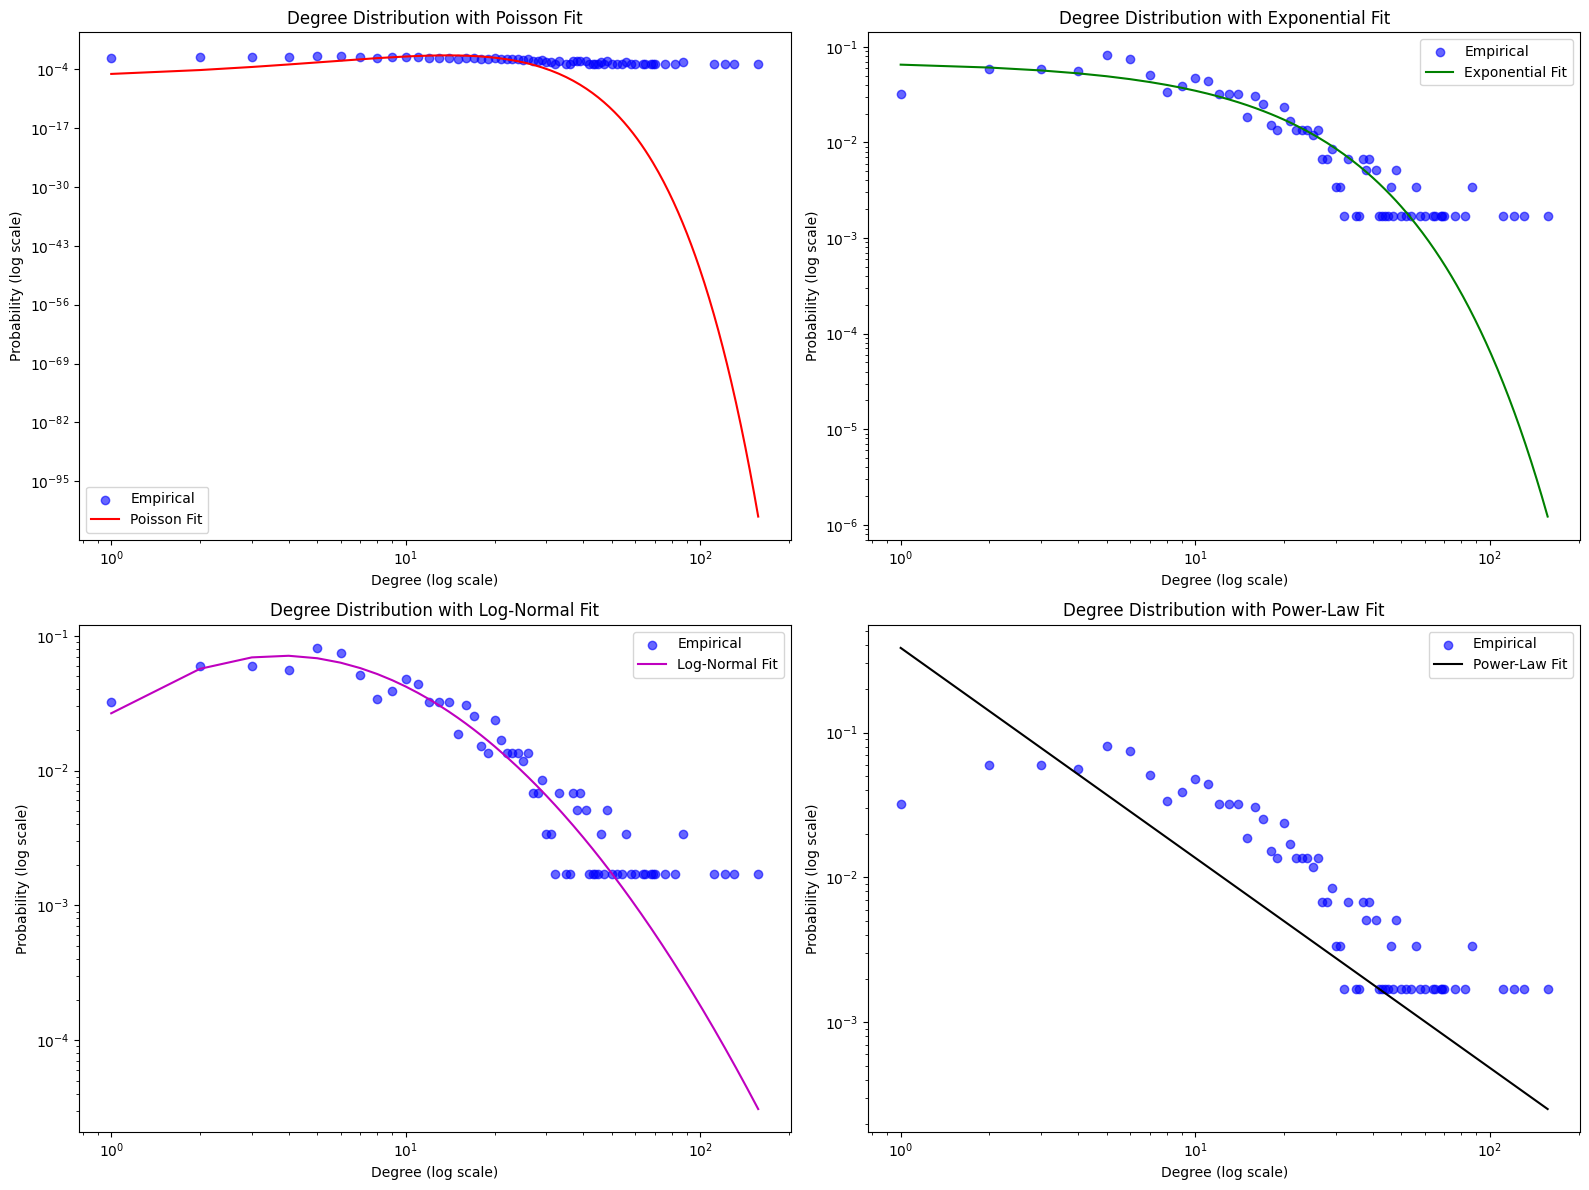

In [197]:
def plot_all_models_loglog(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max()+1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Degree (log scale)')
        ax.set_ylabel('Probability (log scale)')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()


# Prepare fitted parameters for each model
fitted_models = {
    'Poisson': {'lambda': lambda_poisson},
    'Exponential': {'scale': params_exp[1]},  # scale = 1/lambda
    'Log-Normal': {'sigma': sigma_lognorm, 'loc': loc_lognorm, 'scale': scale_lognorm},
    'Power-Law': {'alpha': alpha_powerlaw, 'xmin': xmin_powerlaw}
}
plot_all_models_loglog(degrees, fitted_models)

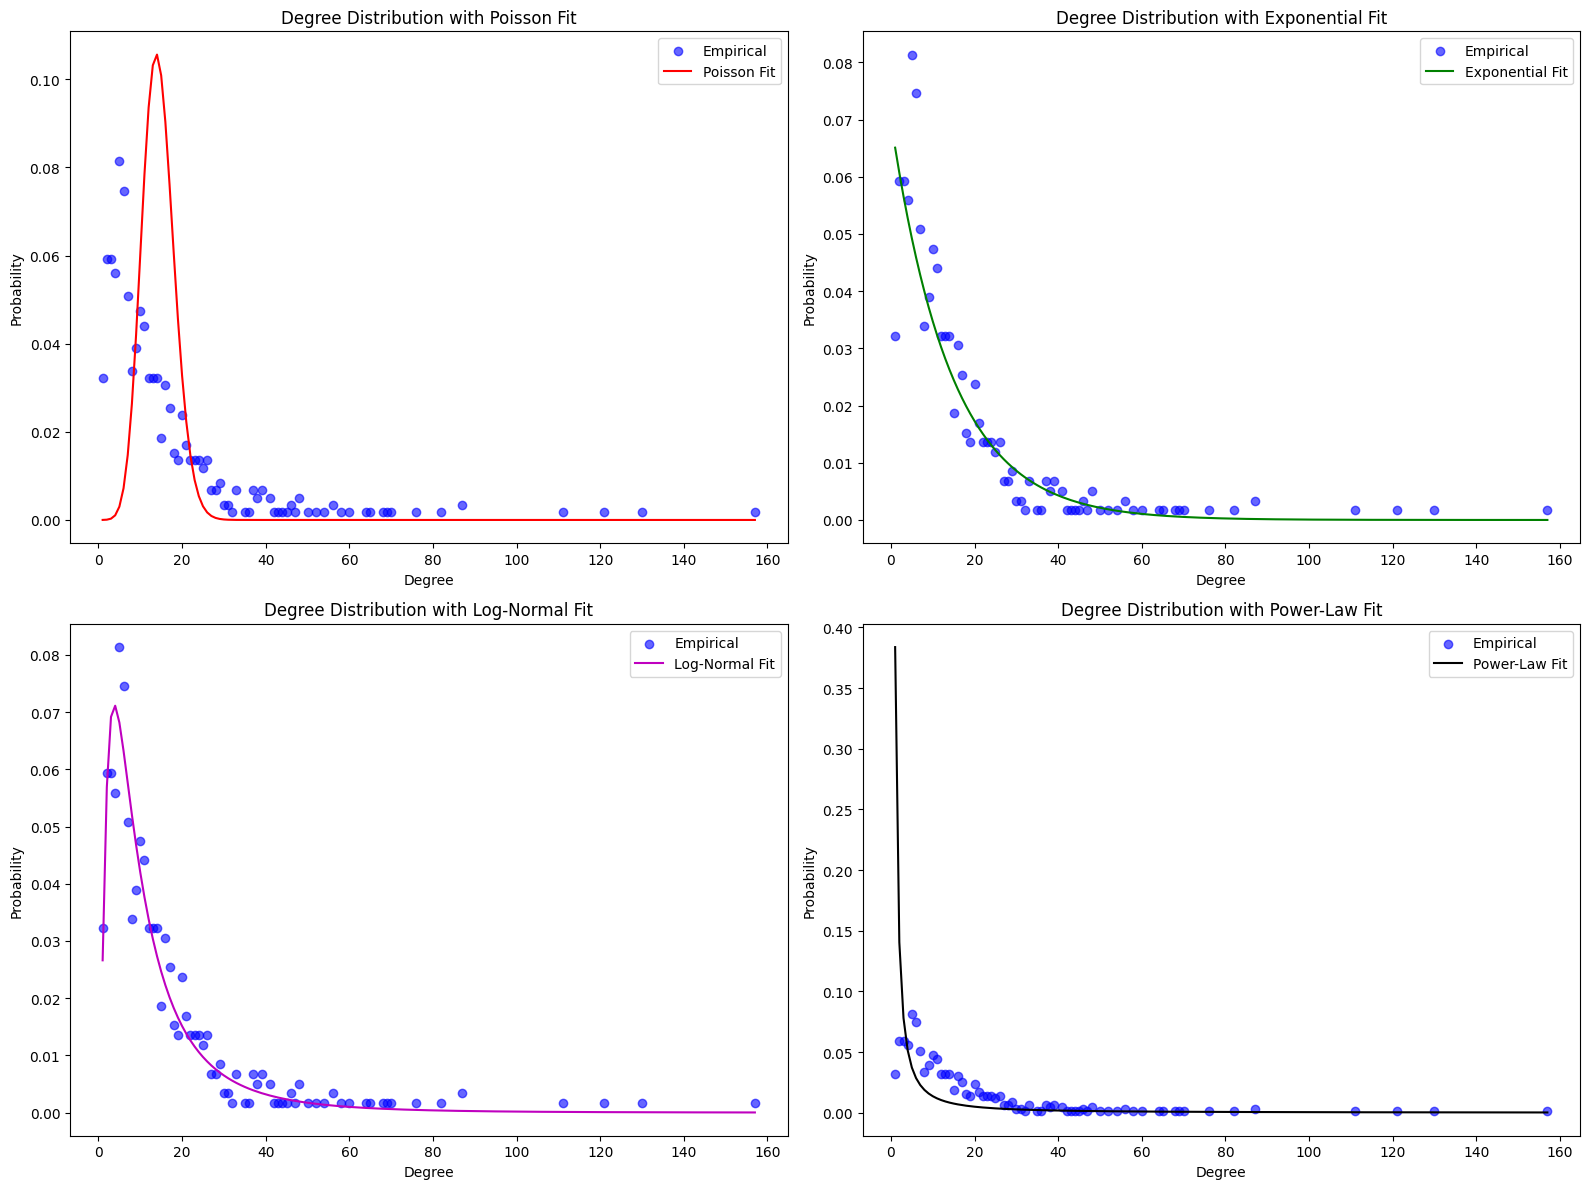

In [198]:
def plot_all_models_linear(degrees, fitted_models):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    models = ['Poisson', 'Exponential', 'Log-Normal', 'Power-Law']
    colors = ['r', 'g', 'm', 'k']
    
    for ax, model, color in zip(axes.flatten(), models, colors):
        # Empirical degree distribution
        degree_counts = np.bincount(degrees)
        degrees_unique = np.nonzero(degree_counts)[0]
        counts = degree_counts[degrees_unique]
        prob = counts / counts.sum()
        
        ax.scatter(degrees_unique, prob, color='blue', marker='o', label='Empirical', alpha=0.6)
        
        # Generate degrees for plotting fitted model
        x = np.arange(degrees_unique.min(), degrees_unique.max() + 1)
        
        if model == 'Poisson':
            pmf = poisson.pmf(x, fitted_models['Poisson']['lambda'])
            ax.plot(x, pmf, color=color, linestyle='-', label='Poisson Fit')
        elif model == 'Exponential':
            pdf = expon.pdf(x, scale=fitted_models['Exponential']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Exponential Fit')
        elif model == 'Log-Normal':
            pdf = lognorm.pdf(x, fitted_models['Log-Normal']['sigma'], loc=fitted_models['Log-Normal']['loc'], scale=fitted_models['Log-Normal']['scale'])
            ax.plot(x, pdf, color=color, linestyle='-', label='Log-Normal Fit')
        elif model == 'Power-Law':
            pdf = (x ** (-fitted_models['Power-Law']['alpha']))
            pdf = pdf / pdf.sum()
            ax.plot(x[x >= fitted_models['Power-Law']['xmin']], pdf[x >= fitted_models['Power-Law']['xmin']], color=color, linestyle='-', label='Power-Law Fit')
        
        ax.set_xlabel('Degree')
        ax.set_ylabel('Probability')
        ax.set_title(f'Degree Distribution with {model} Fit')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# Call the new function
plot_all_models_linear(degrees, fitted_models)

### Nodes analysis (like centrality)

In [199]:
# Get degrees for nodes in the filtered graph (S_subfields)
degree_dict_subfields = dict(S_subfields.degree())

# Combine node names and degrees
degree_data_subfields = [
    {'node': node, 'degree': degree} for node, degree in degree_dict_subfields.items()
]

# Sort nodes by degree in descending order
degree_data_subfields = sorted(degree_data_subfields, key=lambda x: x['degree'], reverse=True)

# Separate data for plotting
nodes_subfields = [entry['node'] for entry in degree_data_subfields]
degrees_subfields = [entry['degree'] for entry in degree_data_subfields]

# Create an interactive bar plot using Plotly
fig = go.Figure(
    data=[
        go.Bar(
            x=list(range(len(nodes_subfields))),
            y=degrees_subfields,
            marker_color='blue',  # All bars in blue
            text=nodes_subfields,  # Hover text
            hovertemplate="<b>Node:</b> %{text}<br><b>Degree:</b> %{y}<extra></extra>",
        )
    ]
)

# Customize layout
fig.update_layout(
    title="Node Degrees in Filtered Graph (S_subfields)",
    xaxis_title="Nodes (sorted by degree)",
    yaxis_title="Degree",
    hovermode="x",
    plot_bgcolor="white",
)

fig.show()

In [200]:
# Print top 30 highest centrality nodes
sorted_centrality = sorted(nx.degree_centrality(S_subfields).items(), key=lambda x: x[1], reverse=True)
print("\nTop 30 nodes by degree centrality:")
for node, centrality in sorted_centrality[:30]:
    print(f"Node: {node}, Degree Centrality: {centrality:.4f}")


Top 30 nodes by degree centrality:
Node: Aristotle, Degree Centrality: 0.2666
Node: Immanuel_Kant, Degree Centrality: 0.2207
Node: Plato, Degree Centrality: 0.2054
Node: Karl_Marx, Degree Centrality: 0.1885
Node: Friedrich_Nietzsche, Degree Centrality: 0.1477
Node: David_Hume, Degree Centrality: 0.1477
Node: Ludwig_Wittgenstein, Degree Centrality: 0.1392
Node: Bertrand_Russell, Degree Centrality: 0.1290
Node: Martin_Heidegger, Degree Centrality: 0.1188
Node: René_Descartes, Degree Centrality: 0.1171
Node: Edmund_Husserl, Degree Centrality: 0.1154
Node: Thomas_Aquinas, Degree Centrality: 0.1104
Node: John_Locke, Degree Centrality: 0.1087
Node: Jacques_Derrida, Degree Centrality: 0.1019
Node: Michel_Foucault, Degree Centrality: 0.0985
Node: Sigmund_Freud, Degree Centrality: 0.0951
Node: Heraclitus, Degree Centrality: 0.0951
Node: John_Stuart_Mill, Degree Centrality: 0.0917
Node: Henri_Bergson, Degree Centrality: 0.0883
Node: Arthur_Schopenhauer, Degree Centrality: 0.0849
Node: Baruch_Sp

In [201]:
import plotly.express as px
import pandas as pd

def plot_centrality_comparison(graph, centrality_x, centrality_y, x_label, y_label, title):
    """
    Creates an interactive scatter plot to compare two centrality measures.

    Parameters:
    - graph: NetworkX graph
    - centrality_x: Dictionary of centrality values for x-axis
    - centrality_y: Dictionary of centrality values for y-axis
    - x_label: Label for x-axis
    - y_label: Label for y-axis
    - title: Title of the plot
    """
    # Prepare data for the plot
    data = pd.DataFrame({
        'Node': list(centrality_x.keys()),
        x_label: list(centrality_x.values()),
        y_label: list(centrality_y.values())
    })

    # Create an interactive scatter plot
    fig = px.scatter(
        data,
        x=x_label,
        y=y_label,
        hover_name='Node',  # Display node name on hover
        hover_data={
            x_label: ':.4f',  # Format centrality values
            y_label: ':.4f'
        },
        title=title,
        labels={x_label: x_label, y_label: y_label},
        template="plotly_white"
    )
    
    fig.show()

# Compute centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
page_rank = nx.pagerank(S_subfields)
betweenness_centrality = nx.betweenness_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)
eigenvector_centrality = nx.eigenvector_centrality(S_subfields)
clustering = nx.clustering(S_subfields)

# Plot comparisons
plot_centrality_comparison(S_subfields, degree_centrality, page_rank, 
                           "Degree Centrality", "PageRank", 
                           "Degree Centrality vs PageRank")

plot_centrality_comparison(S_subfields, degree_centrality, betweenness_centrality, 
                           "Degree Centrality", "Betweenness Centrality", 
                           "Degree Centrality vs Betweenness Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, closeness_centrality, 
                           "Degree Centrality", "Closeness Centrality", 
                           "Degree Centrality vs Closeness Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, eigenvector_centrality, 
                           "Degree Centrality", "Eigenvector Centrality", 
                           "Degree Centrality vs Eigenvector Centrality")

plot_centrality_comparison(S_subfields, degree_centrality, clustering, 
                           "Degree Centrality", "Clustering Coefficient", 
                           "Degree Centrality vs Clustering Coefficient")



### Graph of the entire network

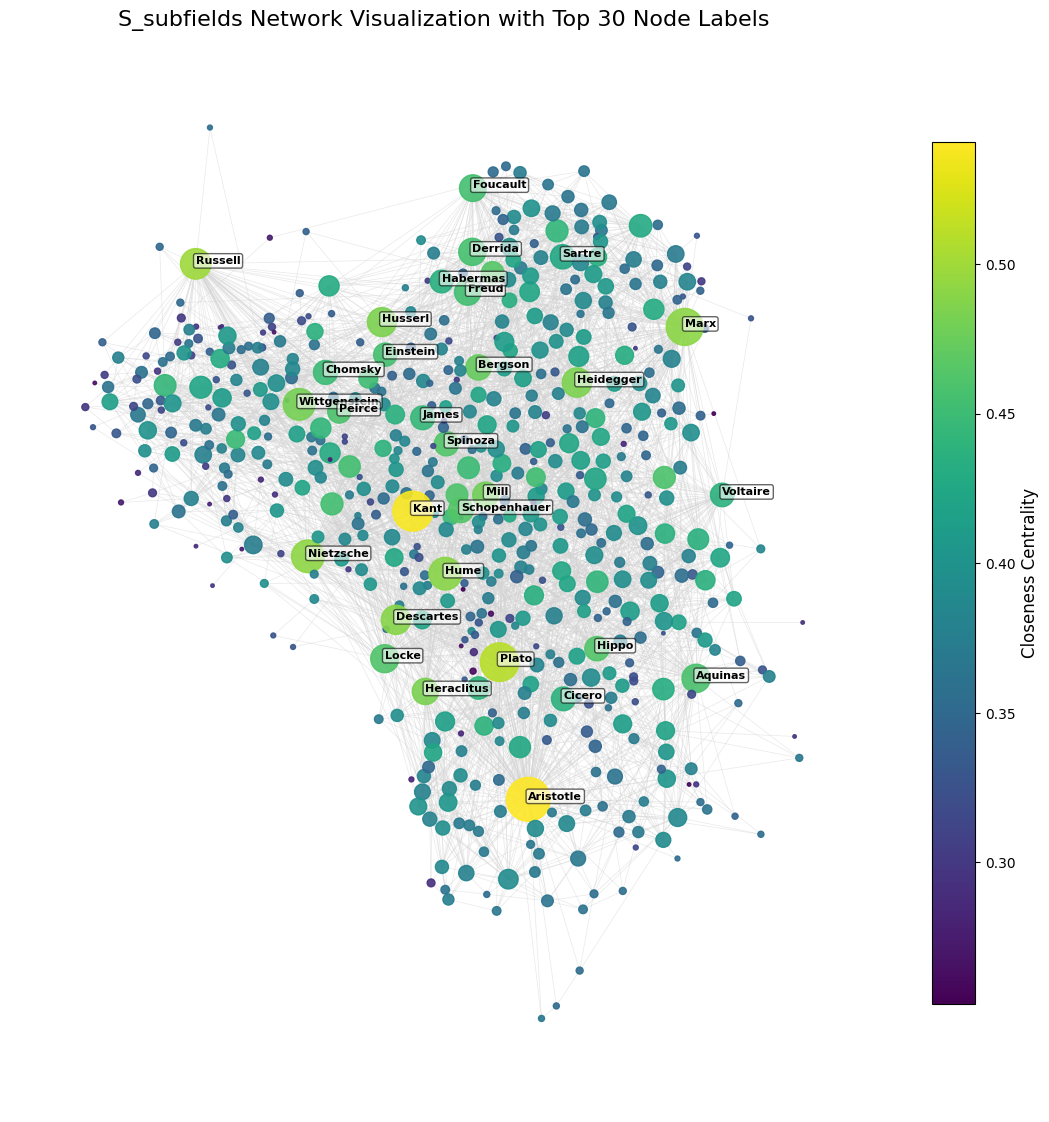

In [202]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np

# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Normalize closeness centrality for node colors
closeness_values = np.array(list(closeness_centrality.values()))
min_closeness, max_closeness = closeness_values.min(), closeness_values.max()
normalized_colors = (closeness_values - min_closeness) / (max_closeness - min_closeness)

# Color map for nodes based on closeness centrality
cmap = plt.cm.viridis
node_colors = [cmap(value) for value in normalized_colors]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Initialize and apply ForceAtlas2 layout
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    edgeWeightInfluence=1.0,
    jitterTolerance=0.05,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    scalingRatio=0.1,
    strongGravityMode=False,
    gravity=0.1,
    verbose=False
)

# Compute positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(S_subfields, pos=None, iterations=2000)

# Plot the network
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_subfields, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_subfields, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding color bar for closeness centrality
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min_closeness, vmax=max_closeness))
sm.set_array([])
cbar = plt.colorbar(sm, shrink=0.8)
cbar.set_label('Closeness Centrality', fontsize=12)

# Add title and turn off axis
plt.title("S_subfields Network Visualization with Top 30 Node Labels", fontsize=16)
plt.axis('off')
plt.show()




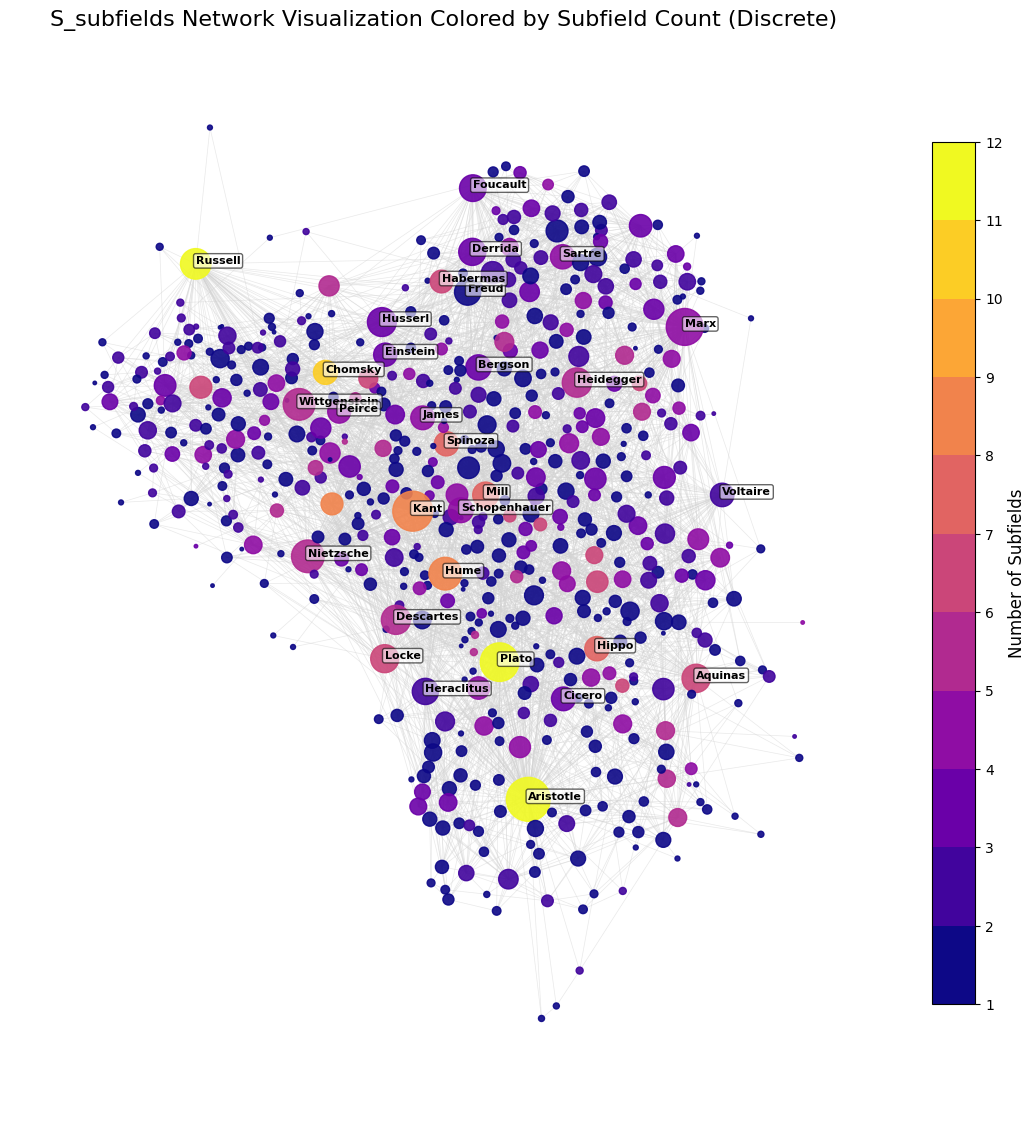

In [218]:

import matplotlib.colors as mcolors

# Calculate centrality measures
degree_centrality = nx.degree_centrality(S_subfields)
closeness_centrality = nx.closeness_centrality(S_subfields)

# Normalize degree centrality for node sizes
max_degree = max(degree_centrality.values())
node_sizes = [1000 * (dc / max_degree) for dc in degree_centrality.values()]

# Get the count of subfields for each node
subfield_counts = {node: len(attrs['subfields']) for node, attrs in S_subfields.nodes(data=True)}

# Define a discrete colormap
max_subfields = max(subfield_counts.values())
bounds = np.arange(1, max_subfields + 2)  # 1 to max_subfields (inclusive)
cmap = plt.cm.plasma
norm = mcolors.BoundaryNorm(bounds, cmap.N)  # Map discrete values to colors

# Map subfield counts to colors
node_colors = [cmap(norm(count)) for count in subfield_counts.values()]

# Sort nodes by degree centrality to find the top 30
top_30_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:30]

# Plot the network
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_subfields, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_subfields, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Add labels for the top 30 nodes (last names or full names)
for node in top_30_nodes:
    last_name = node.split('_')[-1]  # Take the last part of the name after the '_'
    x, y = positions[node]
    plt.text(
        x, y, 
        last_name, 
        fontsize=8, 
        fontweight='bold', 
        color='black', 
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
    )

# Adding discrete color bar for subfield counts
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ticks=bounds, shrink=0.8)
cbar.set_label('Number of Subfields', fontsize=12)

# Add title and turn off axis
plt.title("S_subfields Network Visualization Colored by Subfield Count (Discrete)", fontsize=16)
plt.axis('off')
plt.show()


In [219]:
# Sort nodes by degree centrality in descending order
top_20_nodes = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:20]

# Print the subfields for the top 20 nodes
print("Subfields of the Top 20 Nodes by Degree Centrality:")
for i, node in enumerate(top_20_nodes, start=1):
    subfields = S_subfields.nodes[node].get('subfields', [])
    print(f"{i}. {node}: {', '.join(subfields)}")

Subfields of the Top 20 Nodes by Degree Centrality:
1. Aristotle: aestheticians, epistemologists, ethicists, logicians, metaphysicians, sociopolitical thinkers, philosophers of language, philosophers of mind, philosophers of religion, political philosophers, political theorists
2. Immanuel_Kant: aestheticians, epistemologists, ethicists, metaphysicians, sociopolitical thinkers, philosophers of religion, political philosophers, political theorists
3. Plato: aestheticians, epistemologists, ethicists, logicians, metaphysicians, sociopolitical thinkers, philosophers of language, philosophers of religion, political philosophers, political theorists, rationalists
4. Karl_Marx: secular humanists, sociopolitical thinkers, political philosophers, political theorists
5. Friedrich_Nietzsche: aestheticians, ethicists, sociopolitical thinkers, philosophers of religion, political philosophers
6. David_Hume: aestheticians, epistemologists, ethicists, sociopolitical thinkers, philosophers of mind, phi

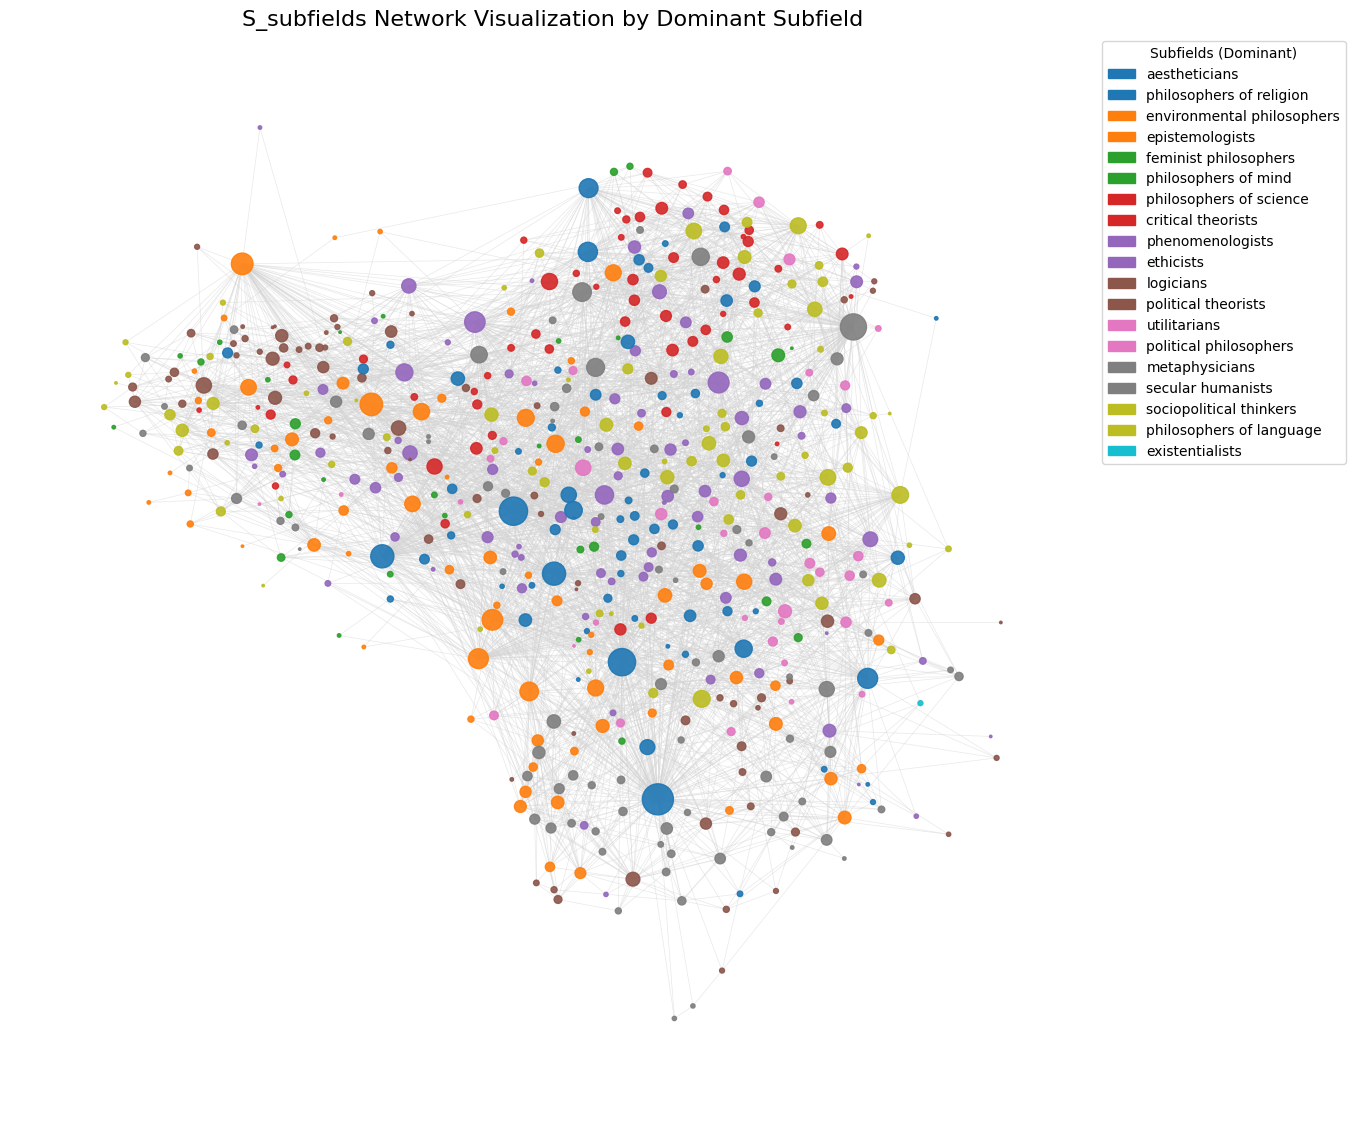

In [203]:
# Example subfield data: Replace with actual subfield attribute for your graph
subfield_data = nx.get_node_attributes(S_subfields, 'subfields')

# Assign a dominant subfield to each node
dominant_subfield = {node: subfields[0] for node, subfields in subfield_data.items()}

# Create a color map for the subfields
unique_subfields = list(set(dominant_subfield.values()))
cmap = plt.cm.tab10  # Choose a colormap
color_map = {subfield: cmap(idx / len(unique_subfields)) for idx, subfield in enumerate(unique_subfields)}

# Assign colors to nodes based on their dominant subfield
node_colors = [color_map[dominant_subfield[node]] for node in S_subfields.nodes()]

# Calculate degree centrality for node sizes
degree_centrality = nx.degree_centrality(S_subfields)
max_degree = max(degree_centrality.values())
node_sizes = [500 * (dc / max_degree) for dc in degree_centrality.values()]


# Plot the network
plt.figure(figsize=(14, 14))
nx.draw_networkx_nodes(
    S_subfields, 
    positions, 
    node_size=node_sizes, 
    node_color=node_colors, 
    alpha=0.9
)
nx.draw_networkx_edges(
    S_subfields, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Create a legend for the subfields
legend_handles = [
    mpatches.Patch(color=color_map[subfield], label=subfield)
    for subfield in unique_subfields
]
plt.legend(
    handles=legend_handles,
    title="Subfields (Dominant)",
    loc="best",
    bbox_to_anchor=(1, 1)
)

# Add title and turn off axis
plt.title("S_subfields Network Visualization by Dominant Subfield", fontsize=16)
plt.axis('off')
plt.show()



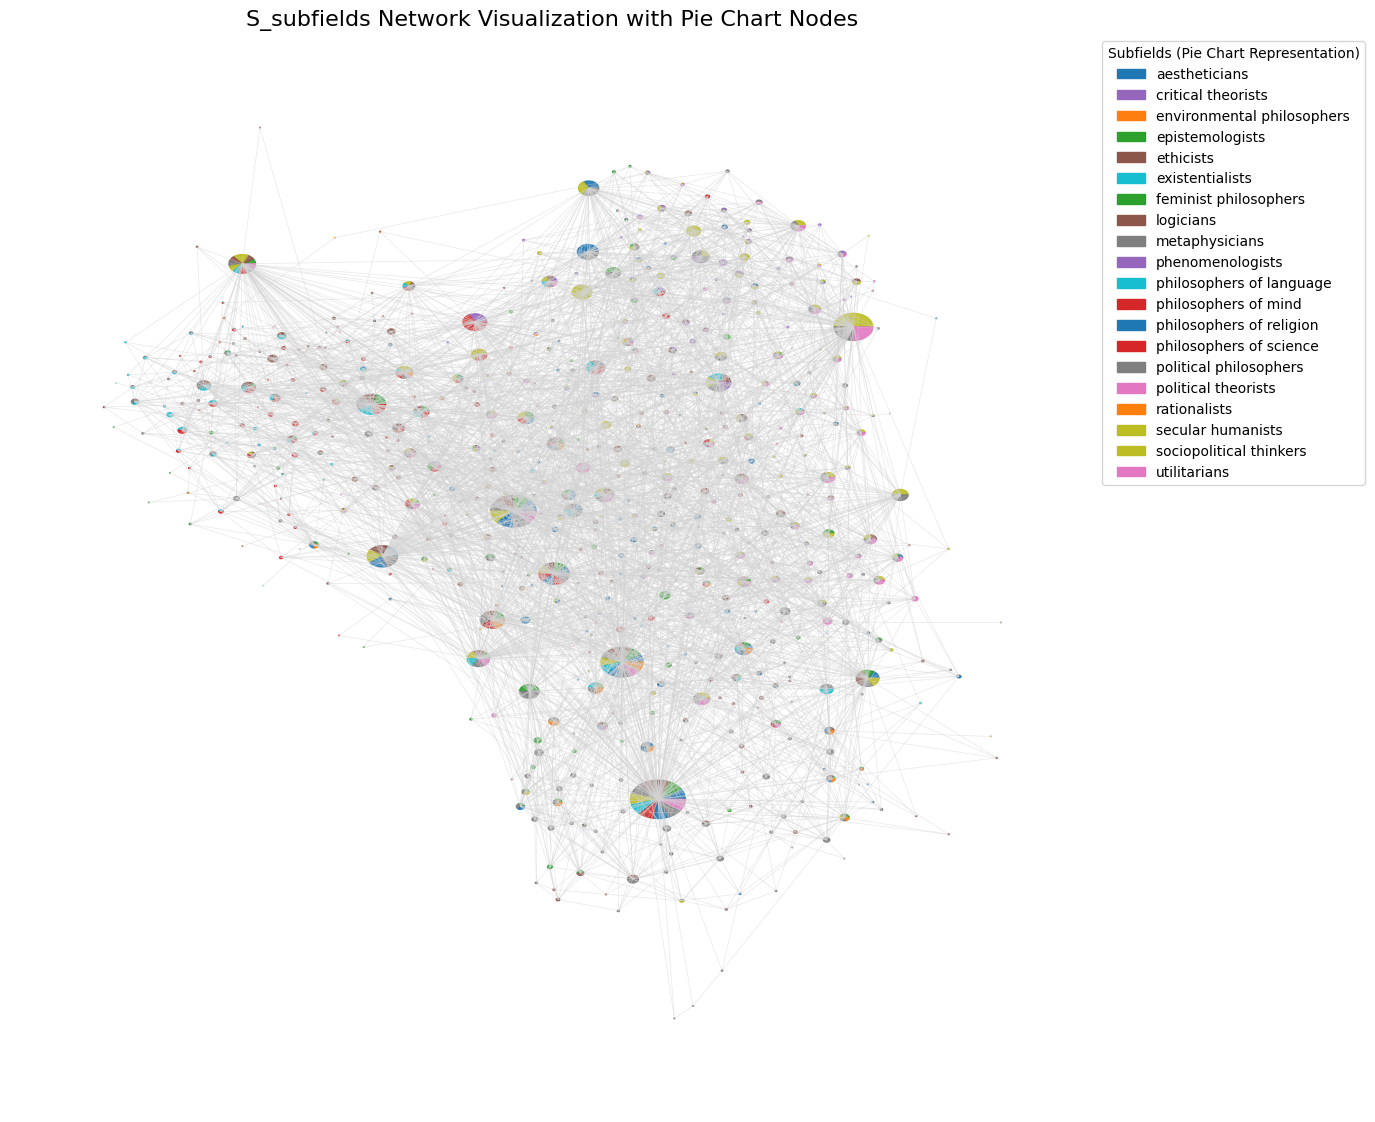

In [205]:
from matplotlib.patches import Wedge
from collections import defaultdict, Counter

# Extract all unique subfields dynamically from the graph
all_subfields = set(
    subfield
    for subfields_list in nx.get_node_attributes(S_subfields, 'subfields').values()
    for subfield in subfields_list
)

# Assign a unique color for each subfield
cmap = plt.cm.tab10
color_map = {subfield: cmap(idx / len(all_subfields)) for idx, subfield in enumerate(all_subfields)}

# Map nodes to their sizes
node_size_map = {node: size for node, size in zip(S_subfields.nodes, node_sizes)}

# Prepare pie chart drawing for each node
def draw_pie(ax, x, y, size, memberships, color_map):
    """Draws a pie chart for a single node."""
    total = sum(memberships.values())
    start_angle = 0
    for subfield, value in memberships.items():
        if subfield not in color_map:
            continue  # Skip any subfield not in the color map
        angle = 360 * (value / total)
        wedge = Wedge((x, y), size, start_angle, start_angle + angle, color=color_map[subfield], alpha=0.9)
        ax.add_patch(wedge)
        start_angle += angle

# Create the plot
fig, ax = plt.subplots(figsize=(14, 14))


# Draw nodes as pie charts
for node, pos in positions.items():
    x, y = pos
    # Extract subfield memberships for the node
    memberships = Counter(nx.get_node_attributes(S_subfields, 'subfields')[node])  # Count occurrences if node has multiple memberships
    draw_pie(ax, x, y, size=node_size_map[node]/100, memberships=memberships, color_map=color_map)

# Draw edges
nx.draw_networkx_edges(
    S_subfields, 
    positions, 
    edge_color='lightgray', 
    alpha=0.5, 
    width=0.5
)

# Create legend
legend_handles = [
    mpatches.Patch(color=color_map[subfield], label=subfield)
    for subfield in sorted(all_subfields)
]
plt.legend(
    handles=legend_handles,
    title="Subfields (Pie Chart Representation)",
    loc="best",
    bbox_to_anchor=(1, 1)
)

# Final touches
plt.title("S_subfields Network Visualization with Pie Chart Nodes", fontsize=16)
plt.axis('off')
plt.show()



## Community specific metrics

Processing subfield: aestheticians
Top 10 nodes by centrality for subfield 'aestheticians':
  Degree Centrality:
    Immanuel_Kant: 0.4800
    Friedrich_Nietzsche: 0.3600
    Jacques_Derrida: 0.2800
    Plato: 0.2800
    Aristotle: 0.2000
    Arthur_Schopenhauer: 0.1800
    David_Hume: 0.1800
    Thomas_Aquinas: 0.1600
    Georges_Bataille: 0.1400
    Plotinus: 0.1400
  Closeness Centrality:
    Immanuel_Kant: 0.5961
    Friedrich_Nietzsche: 0.5426
    Jacques_Derrida: 0.4755
    Plato: 0.4702
    Arthur_Schopenhauer: 0.4651
    Augustine_of_Hippo: 0.4600
    Michel_Foucault: 0.4600
    David_Hume: 0.4600
    Ayn_Rand: 0.4551
    Roger_Scruton: 0.4502
  Betweenness Centrality:
    Immanuel_Kant: 0.3429
    Friedrich_Nietzsche: 0.1533
    Roger_Scruton: 0.0946
    Jacques_Derrida: 0.0903
    Plato: 0.0691
    Arthur_Schopenhauer: 0.0567
    David_Hume: 0.0395
    Friedrich_Schiller: 0.0373
    Aristotle: 0.0361
    Thomas_Aquinas: 0.0357
  Eigenvector Centrality:
    Immanuel_Kant: 0.37

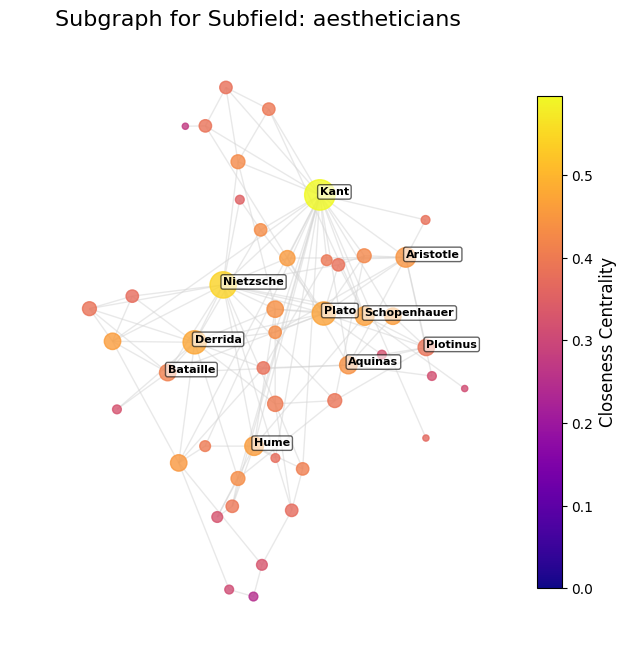

Processing subfield: philosophers of religion
Top 10 nodes by centrality for subfield 'philosophers of religion':
  Degree Centrality:
    Aristotle: 0.3958
    Plato: 0.3750
    Immanuel_Kant: 0.3542
    Maimonides: 0.2708
    Augustine_of_Hippo: 0.2500
    Søren_Kierkegaard: 0.2292
    David_Hume: 0.2292
    Vladimir_Solovyov_(philosopher): 0.1875
    William_James: 0.1667
    Friedrich_Nietzsche: 0.1667
  Closeness Centrality:
    Immanuel_Kant: 0.5450
    Aristotle: 0.5450
    Plato: 0.5450
    Maimonides: 0.4802
    Augustine_of_Hippo: 0.4690
    Søren_Kierkegaard: 0.4636
    Vladimir_Solovyov_(philosopher): 0.4583
    Emanuel_Swedenborg: 0.4532
    Al-Ghazali: 0.4481
    Peter_Abelard: 0.4432
  Betweenness Centrality:
    Aristotle: 0.1768
    Plato: 0.1653
    Immanuel_Kant: 0.1564
    Maimonides: 0.1214
    Vladimir_Solovyov_(philosopher): 0.0861
    David_Hume: 0.0704
    Søren_Kierkegaard: 0.0621
    Anselm_of_Canterbury: 0.0453
    Joseph_ibn_Tzaddik: 0.0450
    Augustine_of

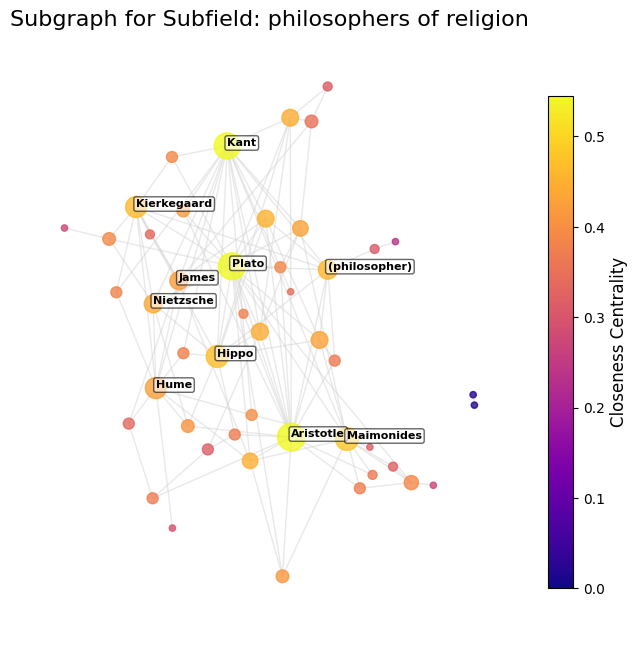

Processing subfield: environmental philosophers
Top 10 nodes by centrality for subfield 'environmental philosophers':
  Degree Centrality:
    Arne_Næss: 0.1429
    Richard_Sylvan: 0.1429
    Roger_Scruton: 0.1429
    Peter_Singer: 0.1429
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
    Mary_Midgley: 0.0000
    Francisco_Varela: 0.0000
  Closeness Centrality:
    Arne_Næss: 0.1429
    Richard_Sylvan: 0.1429
    Roger_Scruton: 0.1429
    Peter_Singer: 0.1429
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
    Mary_Midgley: 0.0000
    Francisco_Varela: 0.0000
  Betweenness Centrality:
    Bruno_Latour: 0.0000
    Arne_Næss: 0.0000
    Richard_Sylvan: 0.0000
    Albert_Schweitzer: 0.0000
    Mary_Midgley: 0.0000
    Roger_Scruton: 0.0000
    Francisco_Varela: 0.0000
    Peter_Singer: 0.0000
  Eigenvector Centrality:
    Arne_Næss: 0.5000
    Richard_Sylvan: 0.5000
    Roger_Scruton: 0.5000
    Peter_Singer: 0.5000
    Bruno_Latour: 0.0000
    Albert_Schweitzer: 0.0000
   

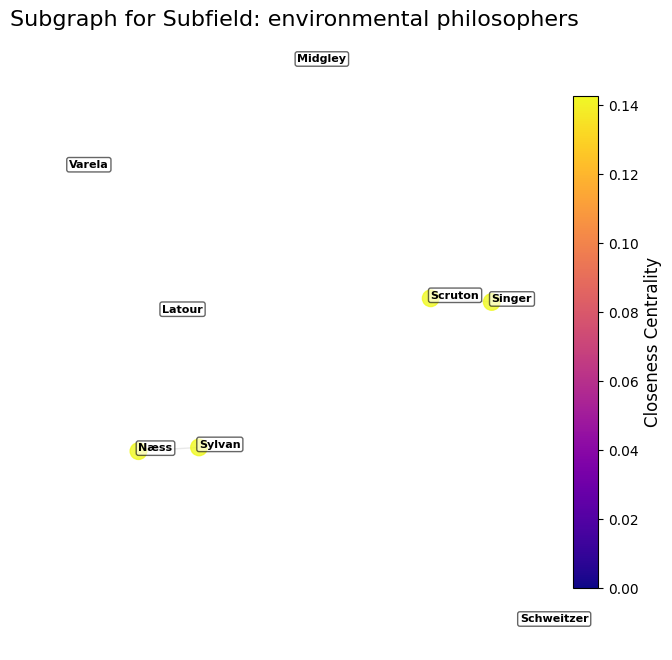

Processing subfield: rationalists
Top 10 nodes by centrality for subfield 'rationalists':
  Degree Centrality:
    Plato: 0.5625
    Maimonides: 0.3750
    Augustine_of_Hippo: 0.3750
    Avicenna: 0.3750
    René_Descartes: 0.3750
    Plotinus: 0.3750
    Averroes: 0.3125
    Al-Farabi: 0.3125
    Pythagoras: 0.3125
    Parmenides: 0.2500
  Closeness Centrality:
    Plato: 0.5833
    Augustine_of_Hippo: 0.5568
    Avicenna: 0.5568
    Maimonides: 0.5326
    René_Descartes: 0.5326
    Plotinus: 0.5104
    Averroes: 0.4712
    Al-Farabi: 0.4712
    Pythagoras: 0.4712
    Baruch_Spinoza: 0.4537
  Betweenness Centrality:
    René_Descartes: 0.1987
    Augustine_of_Hippo: 0.1469
    Avicenna: 0.1013
    Plato: 0.0891
    Maimonides: 0.0806
    Baruch_Spinoza: 0.0507
    Plotinus: 0.0392
    Pythagoras: 0.0205
    Socrates: 0.0187
    Averroes: 0.0114
  Eigenvector Centrality:
    Plato: 0.4557
    Plotinus: 0.3303
    Maimonides: 0.3203
    Avicenna: 0.3110
    Al-Farabi: 0.3039
    Averroe

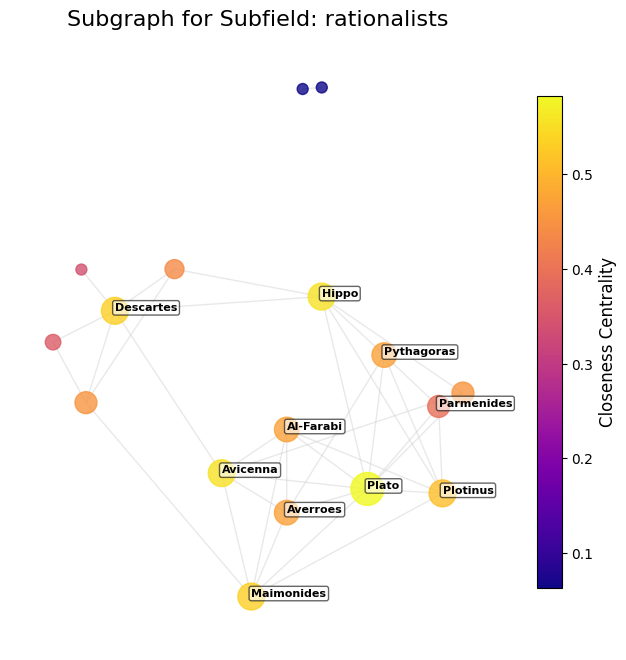

Processing subfield: epistemologists
Top 10 nodes by centrality for subfield 'epistemologists':
  Degree Centrality:
    Aristotle: 0.4286
    Plato: 0.4026
    René_Descartes: 0.3377
    Heraclitus: 0.3117
    Immanuel_Kant: 0.3117
    David_Hume: 0.2987
    Socrates: 0.2208
    Bertrand_Russell: 0.2078
    William_James: 0.2078
    John_Locke: 0.2078
  Closeness Centrality:
    Aristotle: 0.5673
    Immanuel_Kant: 0.5407
    René_Descartes: 0.5365
    Plato: 0.5324
    Heraclitus: 0.5283
    David_Hume: 0.5243
    Bertrand_Russell: 0.4943
    Ludwig_Wittgenstein: 0.4943
    Charles_Sanders_Peirce: 0.4943
    Søren_Kierkegaard: 0.4908
  Betweenness Centrality:
    Aristotle: 0.1186
    Immanuel_Kant: 0.1108
    David_Hume: 0.1059
    Plato: 0.1016
    Heraclitus: 0.0597
    Hilary_Putnam: 0.0523
    René_Descartes: 0.0492
    Alvin_Plantinga: 0.0472
    Thomas_Aquinas: 0.0402
    Baruch_Spinoza: 0.0397
  Eigenvector Centrality:
    Aristotle: 0.3016
    René_Descartes: 0.2632
    Plat

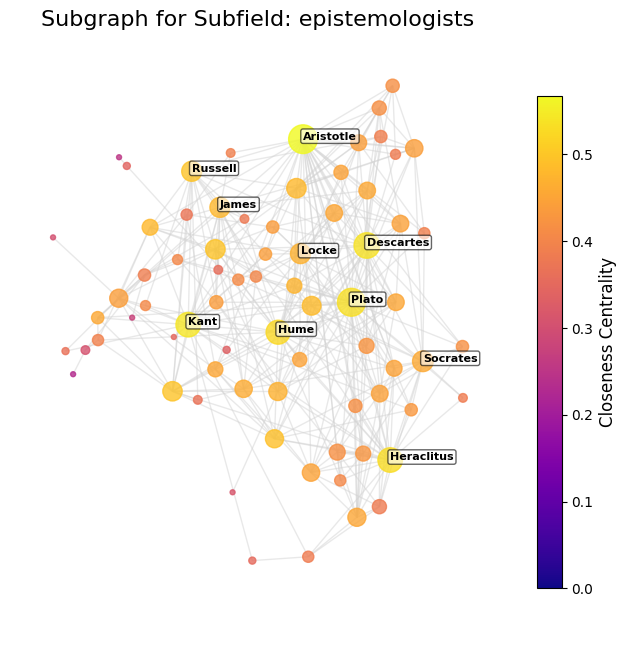

Processing subfield: feminist philosophers
Top 10 nodes by centrality for subfield 'feminist philosophers':
  Degree Centrality:
    Judith_Butler: 0.4091
    Julia_Kristeva: 0.2273
    Hélène_Cixous: 0.1364
    Hannah_Arendt: 0.1364
    Luce_Irigaray: 0.1364
    Avital_Ronell: 0.1364
    Martha_Nussbaum: 0.0909
    Catharine_Macaulay: 0.0909
    Gayatri_Chakravorty_Spivak: 0.0909
    Simone_de_Beauvoir: 0.0909
  Closeness Centrality:
    Judith_Butler: 0.4364
    Julia_Kristeva: 0.3273
    Hannah_Arendt: 0.2975
    Luce_Irigaray: 0.2846
    Avital_Ronell: 0.2846
    Martha_Nussbaum: 0.2727
    Gayatri_Chakravorty_Spivak: 0.2727
    Simone_de_Beauvoir: 0.2727
    Nancy_Fraser: 0.2517
    Michèle_Le_Dœuff: 0.2517
  Betweenness Centrality:
    Judith_Butler: 0.2100
    Martha_Nussbaum: 0.0476
    Hannah_Arendt: 0.0476
    Julia_Kristeva: 0.0310
    Avital_Ronell: 0.0115
    Luce_Irigaray: 0.0072
    Hélène_Cixous: 0.0043
    Catharine_Macaulay: 0.0043
    Routledge_Encyclopedia_of_Philos

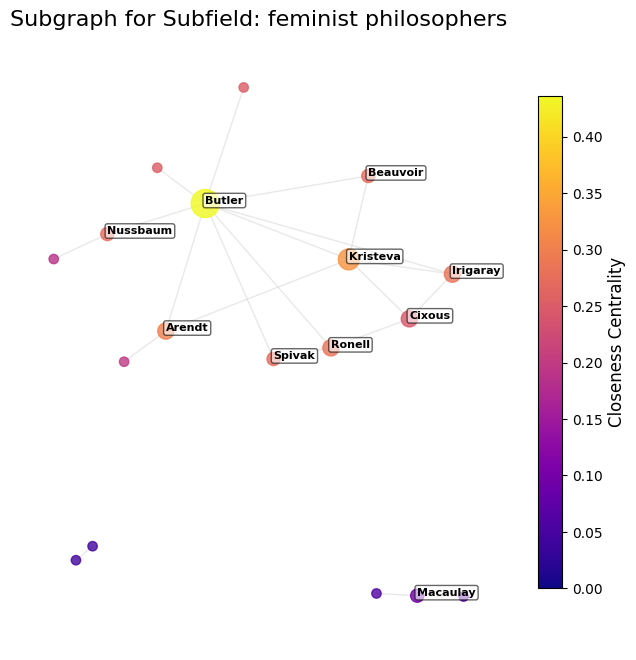

Processing subfield: philosophers of mind
Top 10 nodes by centrality for subfield 'philosophers of mind':
  Degree Centrality:
    Ludwig_Wittgenstein: 0.4464
    Hilary_Putnam: 0.2679
    Noam_Chomsky: 0.2500
    René_Descartes: 0.2500
    David_Hume: 0.2500
    Edmund_Husserl: 0.2321
    Daniel_Dennett: 0.2321
    Gilbert_Ryle: 0.2143
    Donald_Davidson_(philosopher): 0.1964
    William_James: 0.1786
  Closeness Centrality:
    Ludwig_Wittgenstein: 0.5734
    Noam_Chomsky: 0.5049
    Daniel_Dennett: 0.4941
    David_Hume: 0.4941
    Gilbert_Ryle: 0.4788
    Hilary_Putnam: 0.4788
    René_Descartes: 0.4739
    Edmund_Husserl: 0.4692
    John_McDowell: 0.4645
    William_James: 0.4645
  Betweenness Centrality:
    Ludwig_Wittgenstein: 0.2562
    René_Descartes: 0.1201
    David_Hume: 0.1121
    Gilbert_Ryle: 0.0807
    Edmund_Husserl: 0.0747
    Hilary_Putnam: 0.0746
    Noam_Chomsky: 0.0726
    Wilfrid_Sellars: 0.0567
    William_James: 0.0538
    Daniel_Dennett: 0.0382
  Eigenvector

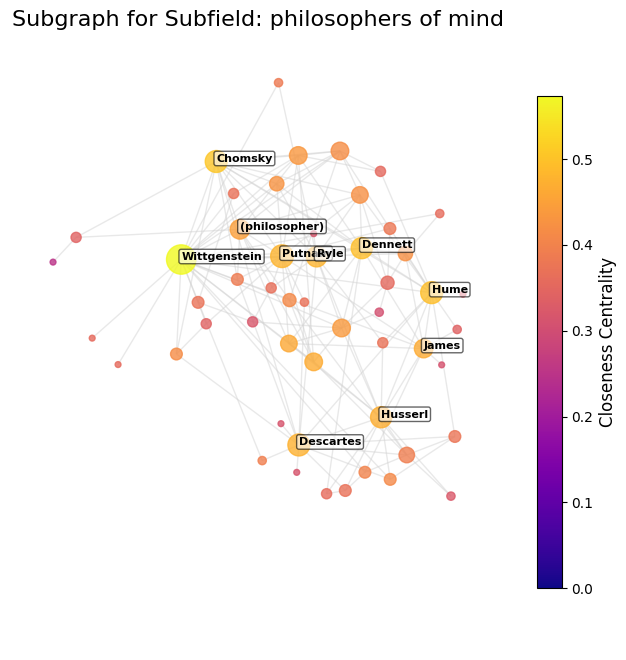

Processing subfield: philosophers of science
Top 10 nodes by centrality for subfield 'philosophers of science':
  Degree Centrality:
    Albert_Einstein: 0.4318
    Paul_Feyerabend: 0.3636
    Karl_Popper: 0.2955
    Bertrand_Russell: 0.2955
    Rudolf_Carnap: 0.2727
    Charles_Sanders_Peirce: 0.2727
    David_Hume: 0.2500
    Hilary_Putnam: 0.2500
    Moritz_Schlick: 0.1818
    Imre_Lakatos: 0.1818
  Closeness Centrality:
    Albert_Einstein: 0.6090
    Paul_Feyerabend: 0.5679
    Karl_Popper: 0.5457
    Rudolf_Carnap: 0.5388
    Charles_Sanders_Peirce: 0.5388
    Bertrand_Russell: 0.5319
    David_Hume: 0.5253
    Hilary_Putnam: 0.5188
    John_Dewey: 0.4886
    Moritz_Schlick: 0.4830
  Betweenness Centrality:
    Albert_Einstein: 0.2284
    Charles_Sanders_Peirce: 0.1522
    Paul_Feyerabend: 0.1446
    Karl_Popper: 0.0995
    Hilary_Putnam: 0.0757
    Rudolf_Carnap: 0.0745
    David_Hume: 0.0721
    Bertrand_Russell: 0.0708
    Roger_Bacon: 0.0419
    Hans_Reichenbach: 0.0333
  Eig

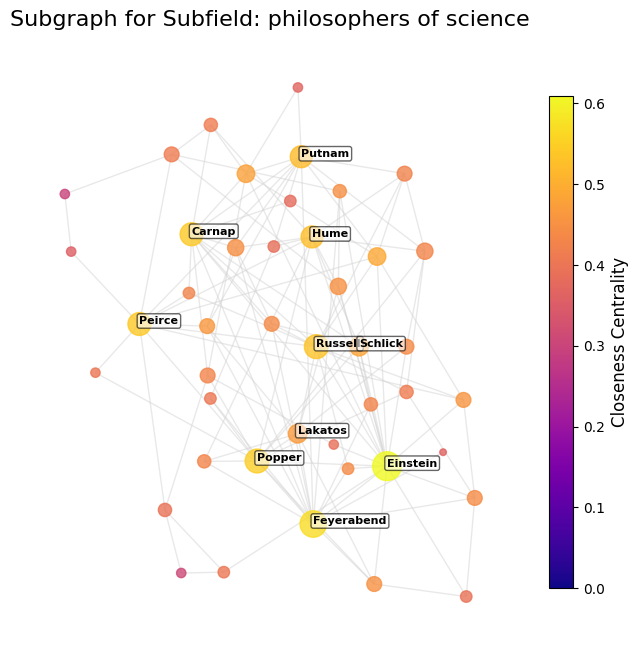

Processing subfield: critical theorists
Top 10 nodes by centrality for subfield 'critical theorists':
  Degree Centrality:
    Jürgen_Habermas: 0.2500
    Herbert_Marcuse: 0.2250
    Fredric_Jameson: 0.2250
    Max_Horkheimer: 0.1750
    Antonio_Gramsci: 0.1750
    Julia_Kristeva: 0.1500
    Paulo_Freire: 0.1250
    Jean_Baudrillard: 0.1250
    Slavoj_Žižek: 0.1250
    Ernesto_Laclau: 0.1000
  Closeness Centrality:
    Fredric_Jameson: 0.4445
    Herbert_Marcuse: 0.4225
    Max_Horkheimer: 0.4074
    Jürgen_Habermas: 0.3980
    Julia_Kristeva: 0.3934
    Antonio_Gramsci: 0.3846
    Paulo_Freire: 0.3528
    Slavoj_Žižek: 0.3492
    Michael_Hardt: 0.3492
    Raymond_Williams: 0.3457
  Betweenness Centrality:
    Fredric_Jameson: 0.2833
    Herbert_Marcuse: 0.2232
    Jürgen_Habermas: 0.2159
    Julia_Kristeva: 0.1824
    Antonio_Gramsci: 0.1615
    Paulo_Freire: 0.1459
    Jean_Baudrillard: 0.1094
    Max_Horkheimer: 0.0967
    Michael_Hardt: 0.0950
    Slavoj_Žižek: 0.0613
  Eigenvector

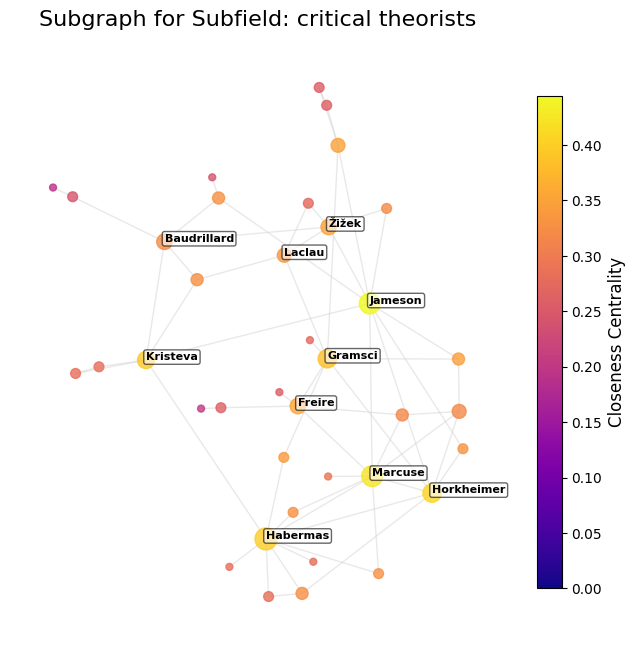

Processing subfield: phenomenologists
Top 10 nodes by centrality for subfield 'phenomenologists':
  Degree Centrality:
    Edmund_Husserl: 1.0000
    Martin_Heidegger: 0.6000
    Maurice_Merleau-Ponty: 0.4000
    Jean-Paul_Sartre: 0.4000
    Edith_Stein: 0.3000
    Emmanuel_Levinas: 0.3000
    Roman_Ingarden: 0.2000
    Hannah_Arendt: 0.2000
    Aron_Gurwitsch: 0.2000
    Herbert_Spiegelberg: 0.1000
  Closeness Centrality:
    Edmund_Husserl: 1.0000
    Martin_Heidegger: 0.7143
    Maurice_Merleau-Ponty: 0.6250
    Jean-Paul_Sartre: 0.6250
    Edith_Stein: 0.5882
    Emmanuel_Levinas: 0.5882
    Roman_Ingarden: 0.5556
    Hannah_Arendt: 0.5556
    Aron_Gurwitsch: 0.5556
    Herbert_Spiegelberg: 0.5263
  Betweenness Centrality:
    Edmund_Husserl: 0.6741
    Martin_Heidegger: 0.0852
    Maurice_Merleau-Ponty: 0.0222
    Edith_Stein: 0.0111
    Jean-Paul_Sartre: 0.0074
    Herbert_Spiegelberg: 0.0000
    Emmanuel_Levinas: 0.0000
    Alfred_Schütz: 0.0000
    Roman_Ingarden: 0.0000
    Ha

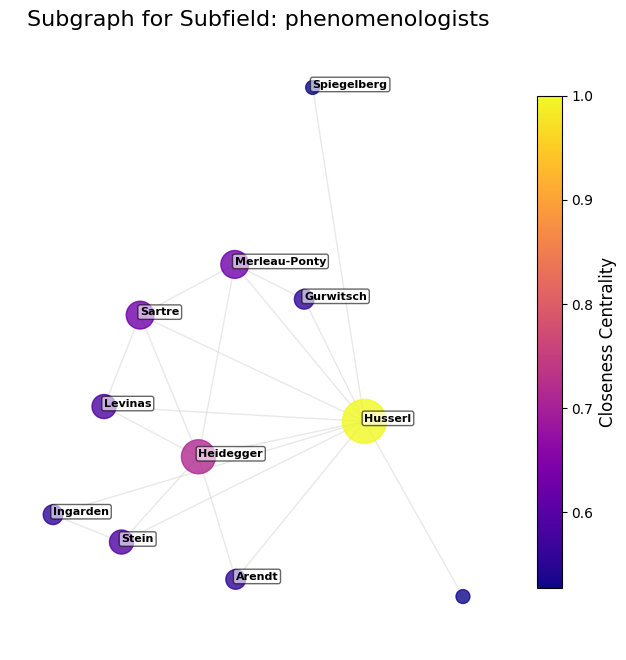

Processing subfield: ethicists
Top 10 nodes by centrality for subfield 'ethicists':
  Degree Centrality:
    Immanuel_Kant: 0.3805
    David_Hume: 0.2832
    Aristotle: 0.2566
    Friedrich_Nietzsche: 0.2478
    Plato: 0.2124
    Arthur_Schopenhauer: 0.1947
    John_Stuart_Mill: 0.1947
    John_Locke: 0.1947
    Thomas_Aquinas: 0.1593
    Bertrand_Russell: 0.1593
  Closeness Centrality:
    Immanuel_Kant: 0.5757
    David_Hume: 0.5381
    Friedrich_Nietzsche: 0.5223
    Aristotle: 0.5173
    John_Stuart_Mill: 0.5027
    Plato: 0.4957
    Bertrand_Russell: 0.4889
    John_Locke: 0.4823
    Arthur_Schopenhauer: 0.4802
    Thomas_Aquinas: 0.4676
  Betweenness Centrality:
    Immanuel_Kant: 0.1894
    David_Hume: 0.1175
    Aristotle: 0.1045
    Friedrich_Nietzsche: 0.0866
    Arthur_Schopenhauer: 0.0627
    John_Stuart_Mill: 0.0612
    Plato: 0.0562
    Bertrand_Russell: 0.0419
    Thomas_Aquinas: 0.0397
    Martin_Heidegger: 0.0373
  Eigenvector Centrality:
    Immanuel_Kant: 0.3510
    

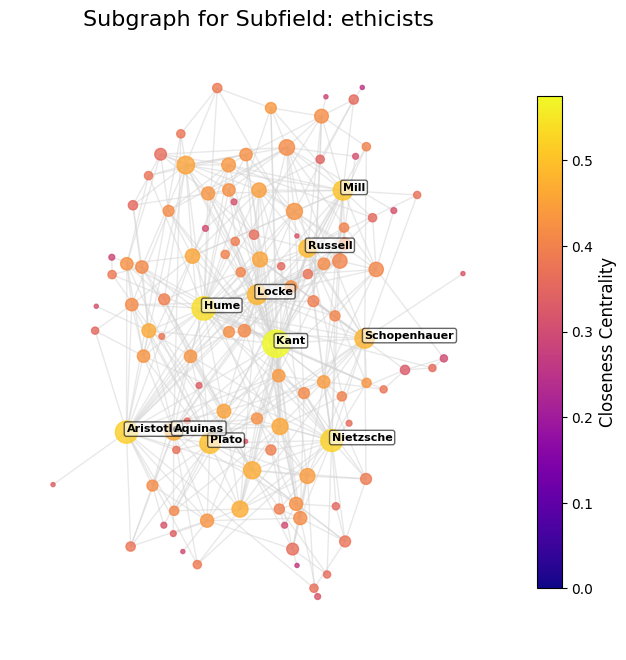

Processing subfield: logicians
Top 10 nodes by centrality for subfield 'logicians':
  Degree Centrality:
    Aristotle: 0.4091
    Bertrand_Russell: 0.2841
    Gottlob_Frege: 0.2273
    Charles_Sanders_Peirce: 0.2273
    Alfred_Tarski: 0.2045
    Ludwig_Wittgenstein: 0.2045
    Kurt_Gödel: 0.2045
    Alfred_North_Whitehead: 0.1477
    Georg_Cantor: 0.1477
    Plato: 0.1364
  Closeness Centrality:
    Aristotle: 0.5810
    Bertrand_Russell: 0.5345
    Gottlob_Frege: 0.5107
    Charles_Sanders_Peirce: 0.5011
    Alfred_Tarski: 0.4889
    Kurt_Gödel: 0.4830
    Georg_Cantor: 0.4689
    Jaakko_Hintikka: 0.4662
    René_Descartes: 0.4582
    Alfred_North_Whitehead: 0.4530
  Betweenness Centrality:
    Aristotle: 0.4017
    Alfred_Tarski: 0.1372
    Bertrand_Russell: 0.1251
    Charles_Sanders_Peirce: 0.0919
    Kurt_Gödel: 0.0732
    Ludwig_Wittgenstein: 0.0723
    Gottlob_Frege: 0.0594
    Georg_Cantor: 0.0556
    René_Descartes: 0.0418
    Alfred_North_Whitehead: 0.0341
  Eigenvector Cent

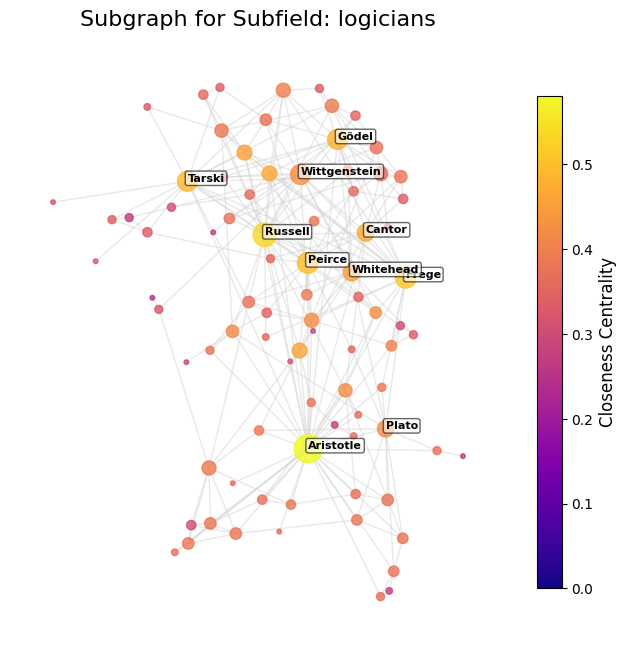

Processing subfield: political theorists
Top 10 nodes by centrality for subfield 'political theorists':
  Degree Centrality:
    Karl_Marx: 0.4722
    John_Locke: 0.2500
    Adam_Smith: 0.2500
    Aristotle: 0.2361
    Leo_Strauss: 0.2222
    Friedrich_Hayek: 0.2222
    Plato: 0.2222
    Immanuel_Kant: 0.2083
    Edmund_Burke: 0.2083
    Vladimir_Lenin: 0.2083
  Closeness Centrality:
    Karl_Marx: 0.6067
    John_Locke: 0.5207
    Adam_Smith: 0.5207
    Friedrich_Hayek: 0.5087
    Edmund_Burke: 0.5009
    John_Stuart_Mill: 0.5009
    Immanuel_Kant: 0.4862
    Noam_Chomsky: 0.4862
    Leo_Strauss: 0.4862
    Aristotle: 0.4792
  Betweenness Centrality:
    Karl_Marx: 0.2494
    Adam_Smith: 0.0733
    Friedrich_Hayek: 0.0659
    Noam_Chomsky: 0.0627
    John_Locke: 0.0573
    Benjamin_Franklin: 0.0528
    Roger_Scruton: 0.0409
    Vladimir_Lenin: 0.0394
    Niccolò_Machiavelli: 0.0389
    Leo_Strauss: 0.0368
  Eigenvector Centrality:
    Karl_Marx: 0.3237
    John_Locke: 0.2138
    Arist

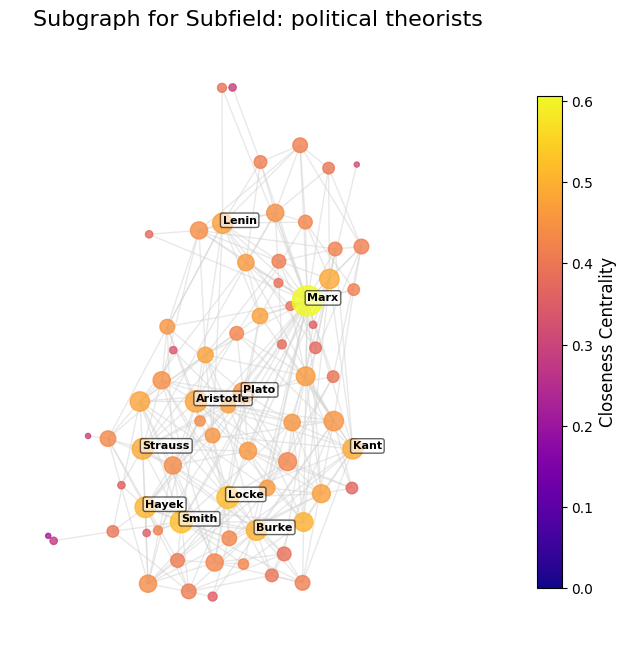

Processing subfield: utilitarians
Top 10 nodes by centrality for subfield 'utilitarians':
  Degree Centrality:
    Jeremy_Bentham: 0.4286
    John_Stuart_Mill: 0.4286
    Henry_Sidgwick: 0.2857
    Francis_Hutcheson_(philosopher): 0.2143
    Charles_Darwin: 0.1786
    Alexander_Bain_(philosopher): 0.1786
    Claude_Adrien_Helvétius: 0.1786
    David_Ricardo: 0.1786
    Michel_Onfray: 0.1429
    James_Mill: 0.1429
  Closeness Centrality:
    Jeremy_Bentham: 0.5414
    John_Stuart_Mill: 0.5275
    Claude_Adrien_Helvétius: 0.4472
    Henry_Sidgwick: 0.4472
    Francis_Hutcheson_(philosopher): 0.4286
    Leslie_Stephen: 0.4198
    Alexander_Bain_(philosopher): 0.4114
    Michel_Onfray: 0.4114
    David_Ricardo: 0.4034
    Joseph_Priestley: 0.4034
  Betweenness Centrality:
    Jeremy_Bentham: 0.2314
    John_Stuart_Mill: 0.1858
    Henry_Sidgwick: 0.1464
    Charles_Darwin: 0.1088
    William_Paley: 0.0825
    Claude_Adrien_Helvétius: 0.0737
    Francis_Hutcheson_(philosopher): 0.0701
    A

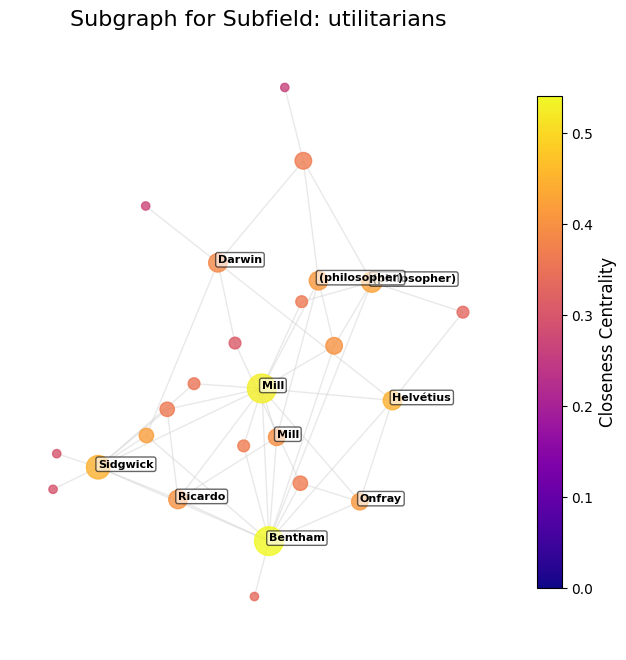

Processing subfield: political philosophers
Top 10 nodes by centrality for subfield 'political philosophers':
  Degree Centrality:
    Karl_Marx: 0.4179
    Aristotle: 0.2612
    Immanuel_Kant: 0.2537
    Friedrich_Nietzsche: 0.2537
    David_Hume: 0.2090
    Plato: 0.2090
    Leo_Strauss: 0.2015
    Voltaire: 0.2015
    John_Locke: 0.2015
    John_Stuart_Mill: 0.1940
  Closeness Centrality:
    Karl_Marx: 0.6111
    Immanuel_Kant: 0.5455
    Friedrich_Nietzsche: 0.5410
    Aristotle: 0.5259
    David_Hume: 0.5238
    John_Locke: 0.5218
    Leo_Strauss: 0.5177
    John_Stuart_Mill: 0.5157
    Voltaire: 0.5117
    Plato: 0.5058
  Betweenness Centrality:
    Karl_Marx: 0.1770
    Friedrich_Nietzsche: 0.0704
    Aristotle: 0.0633
    Immanuel_Kant: 0.0569
    Noam_Chomsky: 0.0527
    David_Hume: 0.0521
    Voltaire: 0.0461
    Plato: 0.0424
    Niccolò_Machiavelli: 0.0377
    John_Locke: 0.0344
  Eigenvector Centrality:
    Karl_Marx: 0.2911
    Immanuel_Kant: 0.2070
    Friedrich_Nietzsc

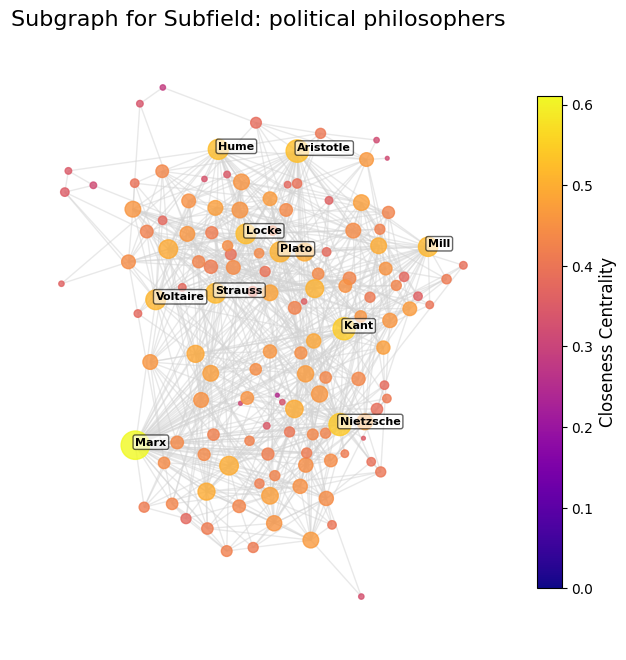

Processing subfield: metaphysicians
Top 10 nodes by centrality for subfield 'metaphysicians':
  Degree Centrality:
    Aristotle: 0.5847
    Plato: 0.4322
    Thomas_Aquinas: 0.3390
    Heraclitus: 0.2458
    Bertrand_Russell: 0.2203
    Plotinus: 0.2203
    Simplicius_of_Cilicia: 0.2119
    Martin_Heidegger: 0.2034
    Immanuel_Kant: 0.2034
    Duns_Scotus: 0.2034
  Closeness Centrality:
    Aristotle: 0.6671
    Plato: 0.5837
    Thomas_Aquinas: 0.5689
    Bertrand_Russell: 0.5213
    Immanuel_Kant: 0.5213
    Heraclitus: 0.5165
    Duns_Scotus: 0.5165
    René_Descartes: 0.5141
    Plotinus: 0.5118
    Martin_Heidegger: 0.5094
  Betweenness Centrality:
    Aristotle: 0.2924
    Thomas_Aquinas: 0.1312
    Plato: 0.1198
    Bertrand_Russell: 0.0686
    Immanuel_Kant: 0.0489
    Alvin_Plantinga: 0.0474
    Martin_Heidegger: 0.0389
    René_Descartes: 0.0385
    Duns_Scotus: 0.0355
    Heraclitus: 0.0311
  Eigenvector Centrality:
    Aristotle: 0.3685
    Plato: 0.2993
    Heraclitus: 0

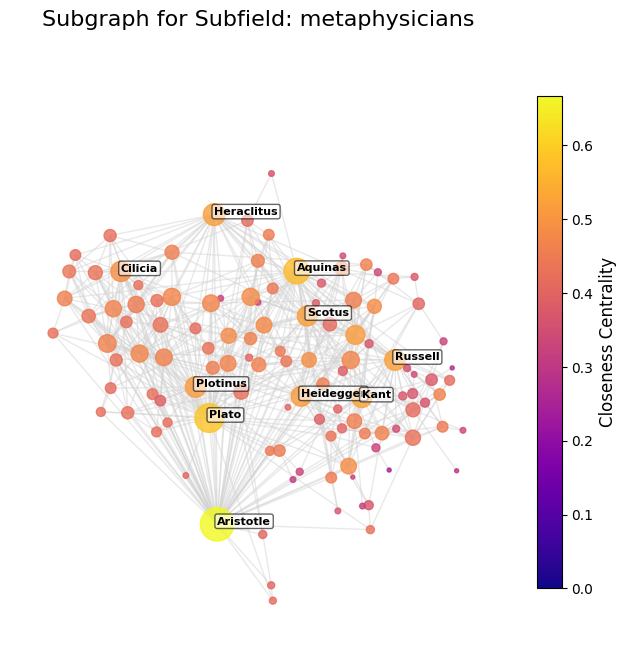

Processing subfield: secular humanists
Top 10 nodes by centrality for subfield 'secular humanists':
  Degree Centrality:
    Karl_Marx: 0.4800
    Albert_Einstein: 0.3600
    Bertrand_Russell: 0.3600
    Sigmund_Freud: 0.2400
    Noam_Chomsky: 0.2400
    Karl_Popper: 0.2400
    John_Dewey: 0.2000
    Martin_Heidegger: 0.2000
    Richard_Rorty: 0.1600
    Mario_Bunge: 0.1600
  Closeness Centrality:
    Karl_Marx: 0.6224
    Bertrand_Russell: 0.5719
    Albert_Einstein: 0.5568
    Sigmund_Freud: 0.5038
    Karl_Popper: 0.5038
    Noam_Chomsky: 0.4921
    John_Dewey: 0.4600
    Mario_Bunge: 0.4318
    Martin_Hägglund: 0.4232
    Pierre-Joseph_Proudhon: 0.4232
  Betweenness Centrality:
    Karl_Marx: 0.3495
    Albert_Einstein: 0.1909
    Bertrand_Russell: 0.1652
    Noam_Chomsky: 0.1068
    Karl_Popper: 0.0666
    Sigmund_Freud: 0.0511
    John_Dewey: 0.0262
    Mario_Bunge: 0.0191
    Daniel_Dennett: 0.0187
    Martin_Heidegger: 0.0173
  Eigenvector Centrality:
    Karl_Marx: 0.4094
    

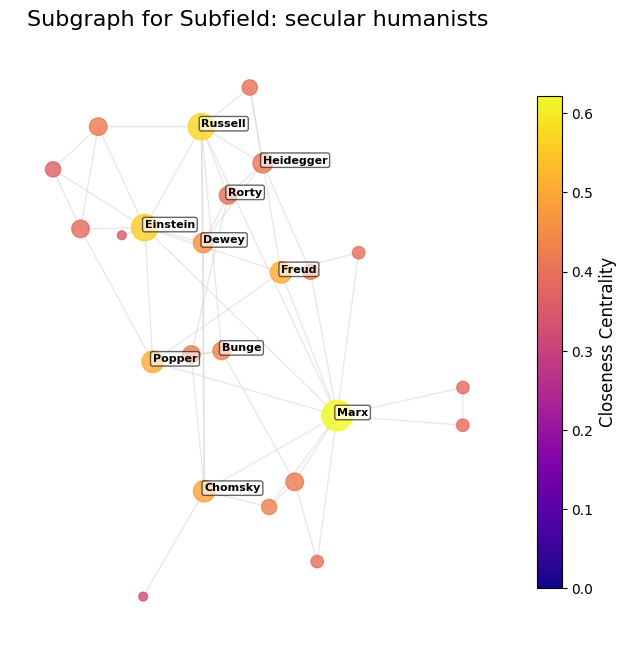

Processing subfield: sociopolitical thinkers
Top 10 nodes by centrality for subfield 'sociopolitical thinkers':
  Degree Centrality:
    Karl_Marx: 0.3889
    Immanuel_Kant: 0.3016
    Aristotle: 0.2778
    Friedrich_Nietzsche: 0.2778
    David_Hume: 0.2302
    Plato: 0.2302
    Michel_Foucault: 0.2143
    John_Stuart_Mill: 0.2143
    Leo_Strauss: 0.1905
    John_Locke: 0.1667
  Closeness Centrality:
    Karl_Marx: 0.5811
    Immanuel_Kant: 0.5547
    Friedrich_Nietzsche: 0.5400
    Aristotle: 0.5237
    David_Hume: 0.5215
    John_Stuart_Mill: 0.5171
    Michel_Foucault: 0.5064
    Plato: 0.5022
    Leo_Strauss: 0.4961
    John_Locke: 0.4921
  Betweenness Centrality:
    Karl_Marx: 0.1645
    Friedrich_Nietzsche: 0.0938
    Aristotle: 0.0798
    Immanuel_Kant: 0.0790
    David_Hume: 0.0711
    Noam_Chomsky: 0.0545
    John_Stuart_Mill: 0.0498
    Voltaire: 0.0489
    Plato: 0.0427
    Michel_Foucault: 0.0345
  Eigenvector Centrality:
    Karl_Marx: 0.2839
    Immanuel_Kant: 0.2484
   

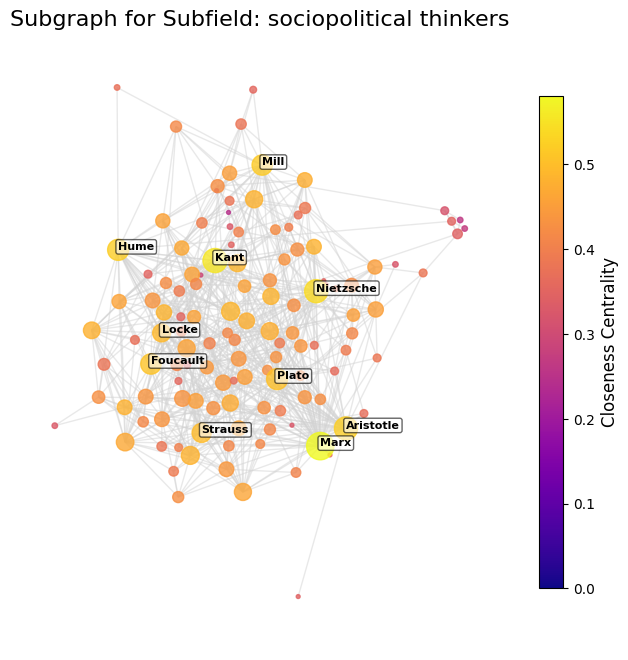

Processing subfield: philosophers of language
Top 10 nodes by centrality for subfield 'philosophers of language':
  Degree Centrality:
    Ludwig_Wittgenstein: 0.4030
    Bertrand_Russell: 0.3731
    Gottlob_Frege: 0.2985
    Noam_Chomsky: 0.2537
    Saul_Kripke: 0.2388
    Aristotle: 0.2388
    Donald_Davidson_(philosopher): 0.2388
    Hilary_Putnam: 0.2239
    Charles_Sanders_Peirce: 0.2090
    John_McDowell: 0.1940
  Closeness Centrality:
    Ludwig_Wittgenstein: 0.5517
    Bertrand_Russell: 0.5517
    Gottlob_Frege: 0.5216
    Saul_Kripke: 0.4946
    Aristotle: 0.4946
    Noam_Chomsky: 0.4946
    Hilary_Putnam: 0.4862
    Donald_Davidson_(philosopher): 0.4742
    John_McDowell: 0.4664
    John_Searle: 0.4627
  Betweenness Centrality:
    Ludwig_Wittgenstein: 0.1593
    Bertrand_Russell: 0.1286
    Noam_Chomsky: 0.1008
    Aristotle: 0.0963
    Saul_Kripke: 0.0664
    Gottlob_Frege: 0.0620
    John_Searle: 0.0582
    Charles_Sanders_Peirce: 0.0491
    Plato: 0.0427
    Donald_Davids

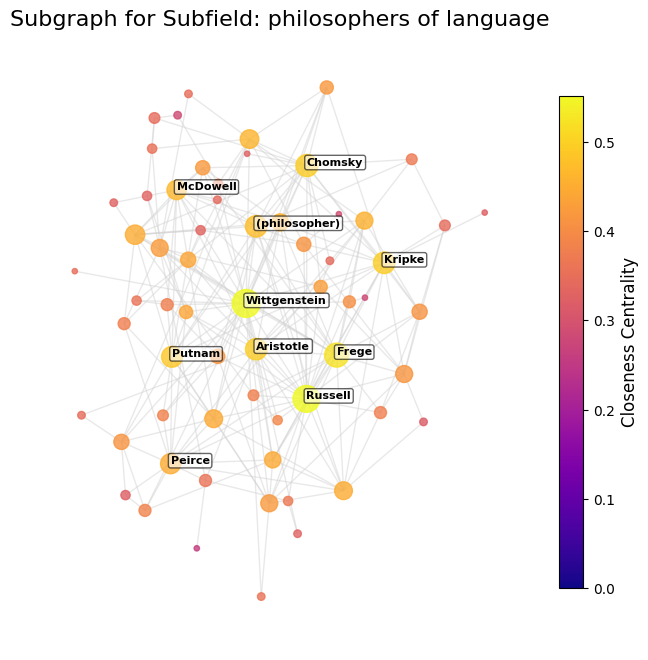

Processing subfield: existentialists
Top 10 nodes by centrality for subfield 'existentialists':
  Degree Centrality:
    Augustine_of_Hippo: 0.5000
    Arthur_Schopenhauer: 0.3333
    Martin_Heidegger: 0.3333
    Max_Stirner: 0.1667
    Paul_Tillich: 0.1667
    Socrates: 0.1667
    Mulla_Sadra: 0.0000
  Closeness Centrality:
    Augustine_of_Hippo: 0.5952
    Arthur_Schopenhauer: 0.4630
    Martin_Heidegger: 0.4630
    Socrates: 0.3788
    Max_Stirner: 0.3205
    Paul_Tillich: 0.3205
    Mulla_Sadra: 0.0000
  Betweenness Centrality:
    Augustine_of_Hippo: 0.5333
    Arthur_Schopenhauer: 0.2667
    Martin_Heidegger: 0.2667
    Mulla_Sadra: 0.0000
    Max_Stirner: 0.0000
    Paul_Tillich: 0.0000
    Socrates: 0.0000
  Eigenvector Centrality:
    Augustine_of_Hippo: 0.6280
    Arthur_Schopenhauer: 0.4440
    Martin_Heidegger: 0.4440
    Socrates: 0.3251
    Max_Stirner: 0.2299
    Paul_Tillich: 0.2299
    Mulla_Sadra: 0.0000
  Pagerank Centrality:
    Augustine_of_Hippo: 0.2752
    Arthu

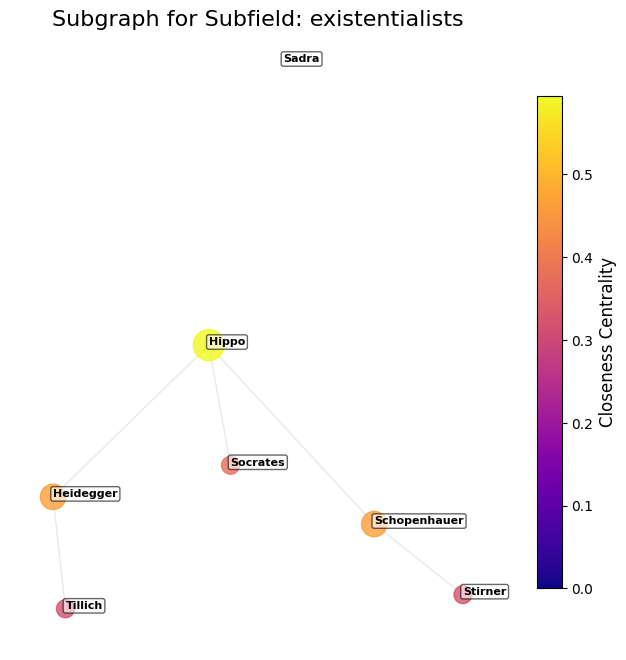

In [224]:
# Function to create subgraphs for each subfield
def create_subfield_subgraphs(graph):
    subfield_subgraphs = {}
    for subfield in set(subfield for subfields in nx.get_node_attributes(graph, 'subfields').values() for subfield in subfields):
        nodes_in_subfield = [
            node for node, data in graph.nodes(data=True) if subfield in data.get('subfields', [])
        ]
        subfield_subgraphs[subfield] = graph.subgraph(nodes_in_subfield).copy()
    return subfield_subgraphs


# Function to compute centrality measures
def compute_centrality_measures(subgraph):
    degree_centrality = nx.degree_centrality(subgraph)
    closeness_centrality = nx.closeness_centrality(subgraph)
    betweenness_centrality = nx.betweenness_centrality(subgraph)
    eigenvector_centrality = nx.eigenvector_centrality(subgraph)
    page_rank = nx.pagerank(subgraph)
    clustering = nx.clustering(subgraph)
    return {
        "degree": degree_centrality,
        "closeness": closeness_centrality,
        "betweenness": betweenness_centrality,
        "eigenvector": eigenvector_centrality,
        "pagerank": page_rank,
        "clustering": clustering
    }


# Function to find the top nodes by each centrality measure
def get_top_nodes_by_centrality(centrality_measures, top_n=5):
    top_nodes = {}
    for measure_name, centrality_dict in centrality_measures.items():
        sorted_nodes = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)[:top_n]
        top_nodes[measure_name] = sorted_nodes
    return top_nodes


# Function to visualize a subgraph
def plot_subgraph(subgraph, centrality_measures, subfield_name, top_n=5):
    # Use degree centrality for node size
    degree_centrality = centrality_measures["degree"]
    node_sizes = [1000 * degree_centrality[node] for node in subgraph.nodes()]

    # Use closeness centrality for node color
    closeness_centrality = centrality_measures["closeness"]
    closeness_values = list(closeness_centrality.values())
    cmap = plt.cm.plasma  # Updated colormap
    norm = plt.Normalize(vmin=min(closeness_values), vmax=max(closeness_values))
    node_colors = [cmap(norm(closeness_centrality[node])) for node in subgraph.nodes()]

    # Compute layout
    forceatlas2 = ForceAtlas2(
        outboundAttractionDistribution=True,
        edgeWeightInfluence=1.0,
        jitterTolerance=0.05,
        barnesHutOptimize=True,
        barnesHutTheta=1.2,
        scalingRatio=0.1,
        strongGravityMode=False,
        gravity=0.1,
        verbose=False
    )
    positions = forceatlas2.forceatlas2_networkx_layout(subgraph, pos=None, iterations=2000)

    # Plot
    plt.figure(figsize=(8, 8))
    nx.draw_networkx_nodes(
        subgraph,
        positions,
        node_size=node_sizes,
        node_color=node_colors,
        alpha=0.8
    )
    nx.draw_networkx_edges(
        subgraph,
        positions,
        edge_color='lightgray',
        alpha=0.5
    )

    # Add labels for the top `n` nodes by degree centrality
    top_degree_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:top_n]
    for node, _ in top_degree_nodes:
        x, y = positions[node]
        last_name = node.split('_')[-1]  # Use last name for labeling
        plt.text(
            x, y,
            last_name,
            fontsize=8,
            fontweight='bold',
            color='black',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
        )

    # Add color bar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, shrink=0.8)
    cbar.set_label('Closeness Centrality', fontsize=12)

    plt.title(f"Subgraph for Subfield: {subfield_name}", fontsize=16)
    plt.axis('off')
    plt.show()


# Function to process and visualize all subfields
def process_and_visualize_subfields(graph, top_n=5):
    subfield_subgraphs = create_subfield_subgraphs(graph)
    for subfield_name, subgraph in subfield_subgraphs.items():
        print(f"Processing subfield: {subfield_name}")
        
        # Compute centrality measures
        centrality_measures = compute_centrality_measures(subgraph)
        
        # Get top nodes by centrality
        top_nodes = get_top_nodes_by_centrality(centrality_measures, top_n)
        
        # Print top nodes
        print(f"Top {top_n} nodes by centrality for subfield '{subfield_name}':")
        for measure, nodes in top_nodes.items():
            print(f"  {measure.capitalize()} Centrality:")
            for node, value in nodes:
                print(f"    {node}: {value:.4f}")
        
        # Plot subgraph
        plot_subgraph(subgraph, centrality_measures, subfield_name, top_n=top_n)


process_and_visualize_subfields(S_subfields, top_n=10)
